# Analysis of Models

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

In [3]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from pmdarima import auto_arima
from sklearn.metrics import root_mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [4]:
# dropping the location column in the dataframes
def drop_location(dataframe):
    return dataframe.drop(columns=['Location'], inplace=True)

In [5]:
def convert_to_datetime(df):
    df['Current_Date'] = pd.to_datetime(df['Current_Date'])
    return df

## Colombo 

In [6]:
colombo_df = pd.read_csv('colombo_df.csv')
colombo_df

HCHO_Reading Location Current_Date
0         0.000197  Colombo   2019-01-01
1         0.000263  Colombo   2019-01-02
2         0.000099  Colombo   2019-01-03
3         0.000210  Colombo   2019-01-04
4         0.000179  Colombo   2019-01-05
...            ...      ...          ...
1275      0.000182  Colombo   2023-12-24
1276      0.000343  Colombo   2023-12-25
1277      0.000118  Colombo   2023-12-27
1278      0.000140  Colombo   2023-12-30
1279      0.000080  Colombo   2023-12-31

[1280 rows x 3 columns]

In [7]:
drop_location(colombo_df)
colombo_df

HCHO_Reading Current_Date
0         0.000197   2019-01-01
1         0.000263   2019-01-02
2         0.000099   2019-01-03
3         0.000210   2019-01-04
4         0.000179   2019-01-05
...            ...          ...
1275      0.000182   2023-12-24
1276      0.000343   2023-12-25
1277      0.000118   2023-12-27
1278      0.000140   2023-12-30
1279      0.000080   2023-12-31

[1280 rows x 2 columns]

In [8]:
convert_to_datetime(colombo_df)

HCHO_Reading Current_Date
0         0.000197   2019-01-01
1         0.000263   2019-01-02
2         0.000099   2019-01-03
3         0.000210   2019-01-04
4         0.000179   2019-01-05
...            ...          ...
1275      0.000182   2023-12-24
1276      0.000343   2023-12-25
1277      0.000118   2023-12-27
1278      0.000140   2023-12-30
1279      0.000080   2023-12-31

[1280 rows x 2 columns]

In [9]:
train_size_col = int(len(colombo_df) * 0.8)
train_col, test_col = colombo_df.iloc[:train_size_col], colombo_df.iloc[train_size_col:]

ARIMA

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-15917.101, Time=1.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-15927.588, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16207.947, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16435.596, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-15929.625, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16433.783, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-16457.846, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-15919.103, Time=0.87 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-16469.773, Time=0.40 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-15917.043, Time=0.56 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-16482.430, Time=0.44 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-16474.351, Time=0.55 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=-16470.719, Time=0.64 sec
 ARIMA(0,1,4

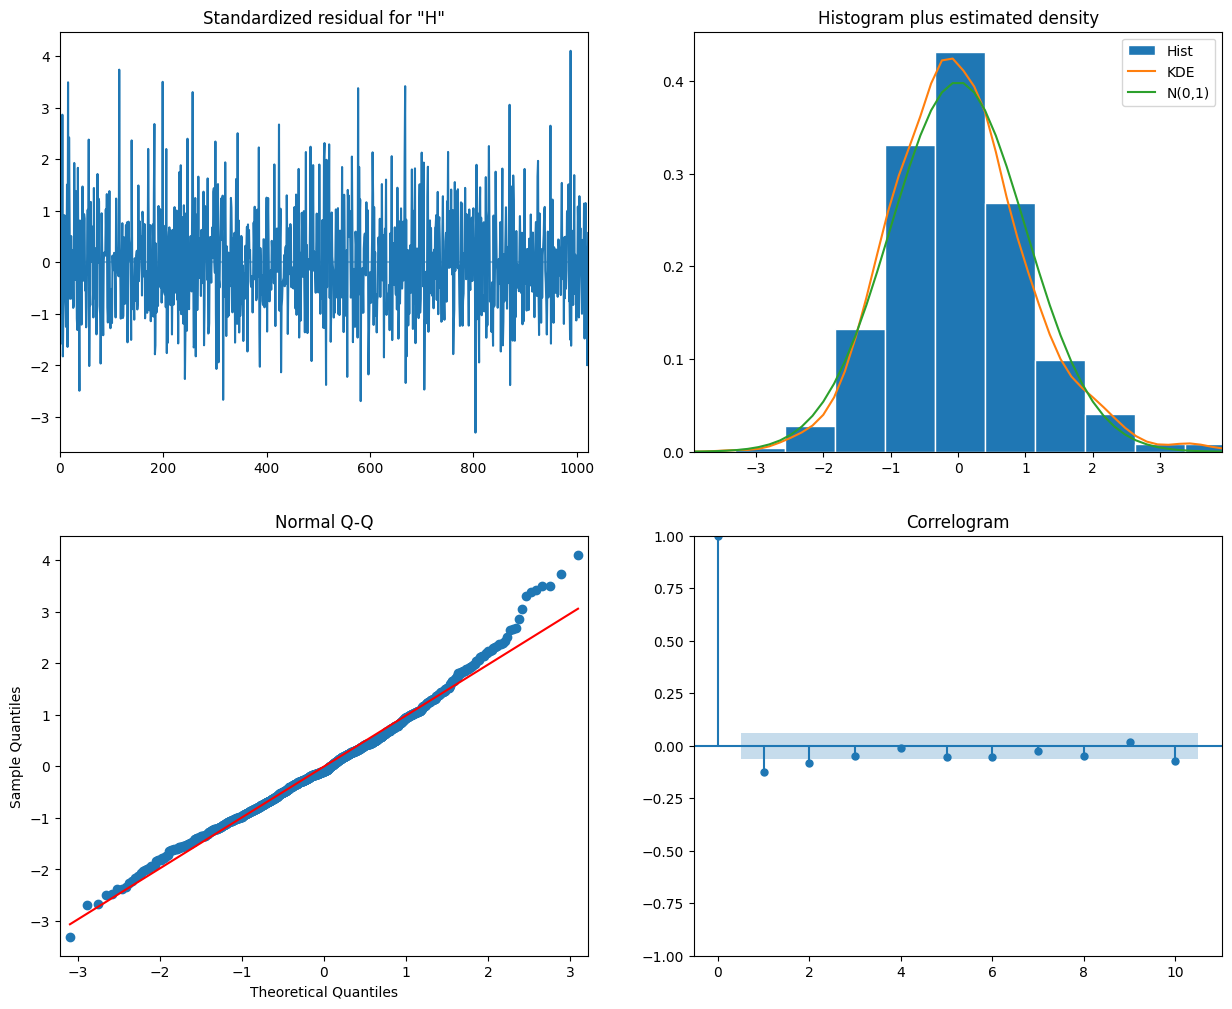

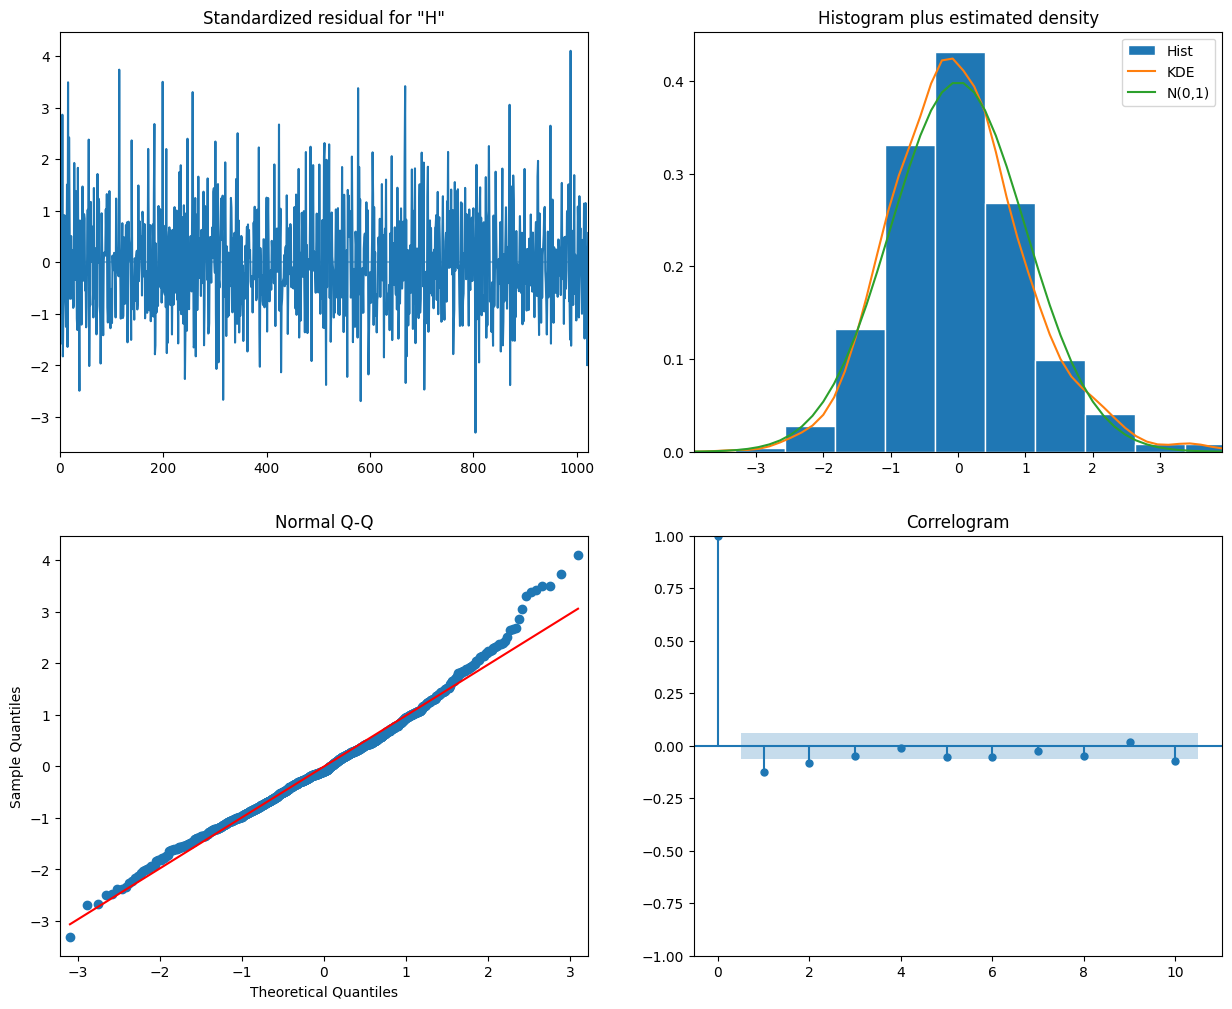

In [10]:
col_arima_model = auto_arima(train_col['HCHO_Reading'], seasonal=True, trace=True)
p,d,q = col_arima_model.order
print(p,d,q)
arima_col = ARIMA(train_col['HCHO_Reading'], order=(p,d,q))
arima_fit_col = arima_col.fit()
print(arima_fit_col.summary())
arima_fit_col.plot_diagnostics(figsize=(15,12))

In [11]:
col_test_preds_arima = arima_fit_col.forecast(steps=len(test_col))
rmse_col = root_mean_squared_error(test_col['HCHO_Reading'], col_test_preds_arima)
print(f'ARIMA RMSE for Colombo: {rmse_col}')
print(col_test_preds_arima)

ARIMA RMSE for Colombo: 8.788177579700709e-05
1024    0.000137
1025    0.000142
1026    0.000142
1027    0.000140
1028    0.000140
          ...   
1275    0.000140
1276    0.000140
1277    0.000140
1278    0.000140
1279    0.000140
Name: predicted_mean, Length: 256, dtype: float64


SARIMA

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-15912.586, Time=2.19 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-15927.588, Time=0.12 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-16205.579, Time=0.48 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-16433.225, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-15929.625, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-16435.596, Time=0.20 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-16433.411, Time=0.55 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=-16431.221, Time=0.88 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-16433.783, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=-16457.846, Time=0.28 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=-16455.679, Time=0.69 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=-16455.441, Time=0.66 sec
 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=-16453.455, Time=0.68 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=-15919.103, Time=

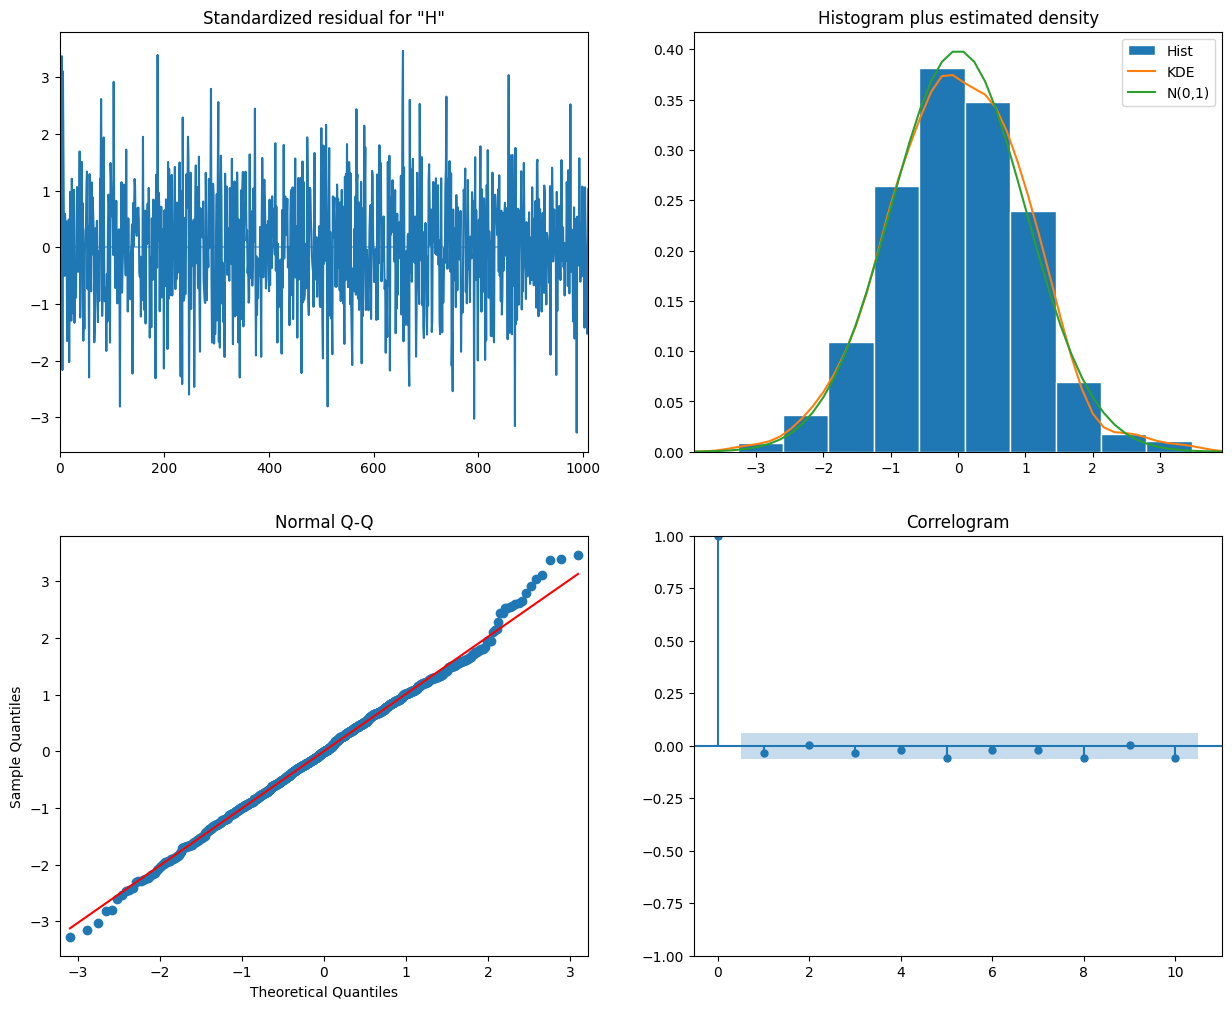

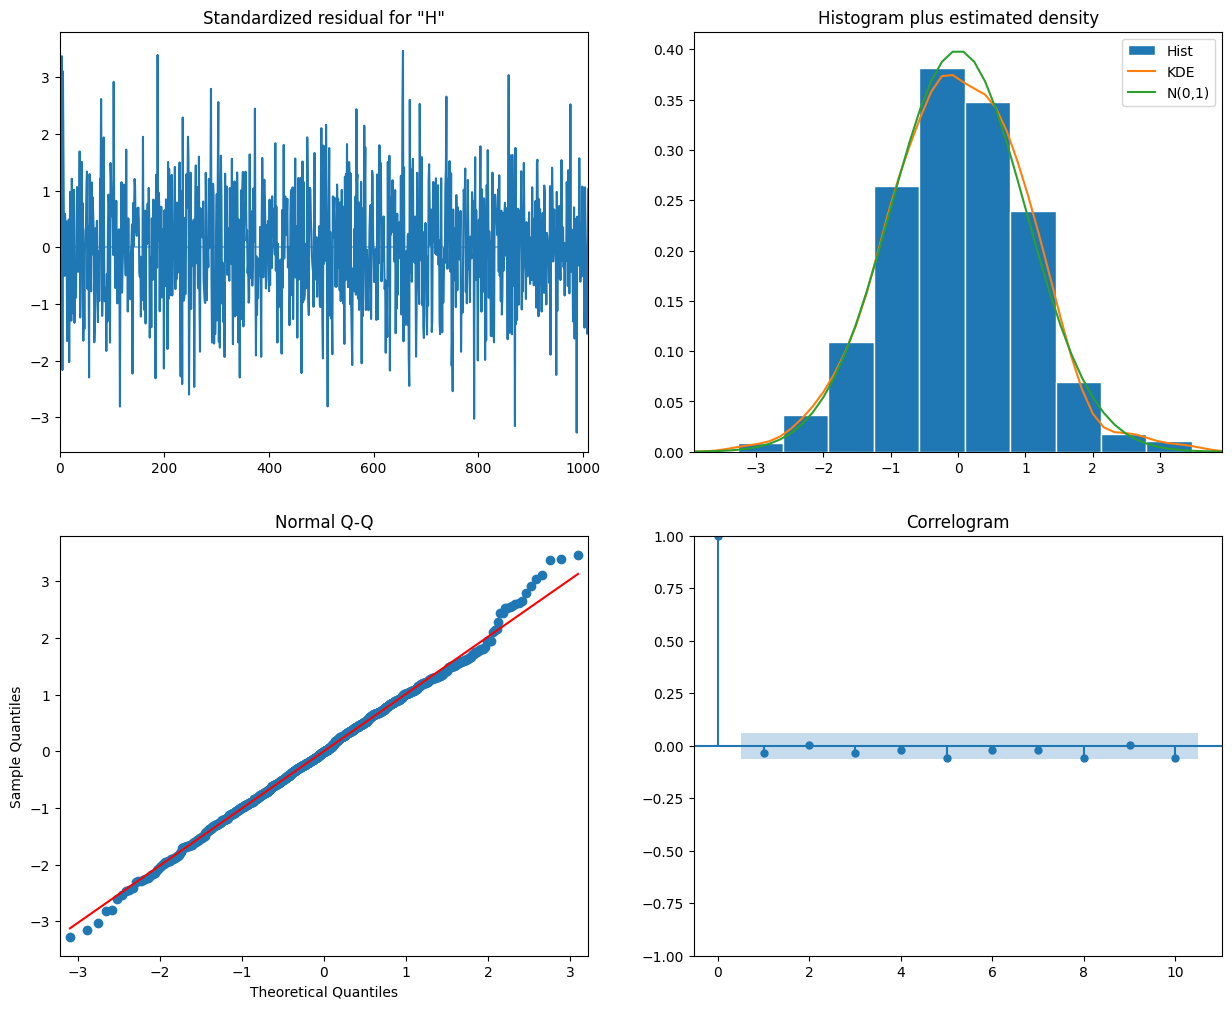

In [12]:
col_sarima_model = auto_arima(train_col['HCHO_Reading'], seasonal=True, trace=True, m=12)
p,d,q = col_sarima_model.order
print(p,d,q)
sarima_col = SARIMAX(train_col['HCHO_Reading'], order=(p,d,q), seasonal_order=(p,d,q,12))
sarima_fit_col = sarima_col.fit()
print(sarima_fit_col.summary())
sarima_fit_col.plot_diagnostics(figsize=(15,12))

In [13]:
col_test_preds_sarima = sarima_fit_col.forecast(steps=len(test_col))
rmse_col_sarima = root_mean_squared_error(test_col['HCHO_Reading'], col_test_preds_sarima)
print(f'SARIMA RMSE for Colombo: {rmse_col_sarima}')
print(col_test_preds_sarima)

SARIMA RMSE for Colombo: 0.0002570807789456736
1024    0.000164
1025    0.000107
1026    0.000137
1027    0.000228
1028    0.000047
          ...   
1275   -0.000220
1276   -0.000223
1277   -0.000280
1278   -0.000251
1279   -0.000160
Name: predicted_mean, Length: 256, dtype: float64


Gaussian Processes

In [14]:
# Define kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp_col = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

gp_col.fit(train_col.index.values.reshape(-1,1), train_col['HCHO_Reading'])

col_test_preds_gp = gp_col.predict(test_col.index.values.reshape(-1,1))
rmse_col_gp = root_mean_squared_error(test_col['HCHO_Reading'], col_test_preds_gp)
print(f'Gaussian Process RMSE for Colombo: {rmse_col_gp}')

Gaussian Process RMSE for Colombo: 0.0004329570046930834


## Matara

In [15]:
matara_df = pd.read_csv('matara_df.csv')
matara_df

HCHO_Reading Location Current_Date
0        0.000006   Matara   2019-01-02
1        0.000236   Matara   2019-01-03
2        0.000064   Matara   2019-01-04
3        0.000053   Matara   2019-01-05
4        0.000132   Matara   2019-01-06
..            ...      ...          ...
847      0.000063   Matara   2023-12-24
848      0.000072   Matara   2023-12-25
849      0.000059   Matara   2023-12-26
850      0.000228   Matara   2023-12-27
851      0.000116   Matara   2023-12-30

[852 rows x 3 columns]

In [16]:
drop_location(matara_df)
matara_df

HCHO_Reading Current_Date
0        0.000006   2019-01-02
1        0.000236   2019-01-03
2        0.000064   2019-01-04
3        0.000053   2019-01-05
4        0.000132   2019-01-06
..            ...          ...
847      0.000063   2023-12-24
848      0.000072   2023-12-25
849      0.000059   2023-12-26
850      0.000228   2023-12-27
851      0.000116   2023-12-30

[852 rows x 2 columns]

In [17]:
convert_to_datetime(matara_df)

HCHO_Reading Current_Date
0        0.000006   2019-01-02
1        0.000236   2019-01-03
2        0.000064   2019-01-04
3        0.000053   2019-01-05
4        0.000132   2019-01-06
..            ...          ...
847      0.000063   2023-12-24
848      0.000072   2023-12-25
849      0.000059   2023-12-26
850      0.000228   2023-12-27
851      0.000116   2023-12-30

[852 rows x 2 columns]

In [18]:
train_size_mat = int(len(matara_df) * 0.8)
train_mat, test_mat = matara_df.iloc[:train_size_mat], matara_df.iloc[train_size_mat:]

ARIMA

Performing stepwise search to minimize aic


 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-11090.809, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-10327.011, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-10828.968, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-10538.846, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-7909.880, Time=0.30 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-8572.524, Time=0.14 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-11090.340, Time=0.36 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-11095.078, Time=0.43 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-11086.921, Time=0.45 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-11095.467, Time=0.53 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=-11093.723, Time=0.54 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=-10312.990, Time=0.55 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-10314.982, Time=0.46 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-11090.264, Time=0.37 sec
 ARIMA(4,0,4)(0,0,0)[0]             : AIC=-10310.9

c:\Users\arkha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:           HCHO_Reading   No. Observations:                  681
Model:                 ARIMA(0, 0, 4)   Log Likelihood                5581.166
Date:                Mon, 15 Apr 2024   AIC                         -11150.331
Time:                        20:03:19   BIC                         -11123.190
Sample:                             0   HQIC                        -11139.826
                                - 681                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   3.77e-06     27.334      0.000    9.57e-05       0.000
ma.L1          0.0618   4.72e-12   1.31e+10      0.000       0.062       0.062
ma.L2          0.0467   1.82e-11   2.57e+09      0.0

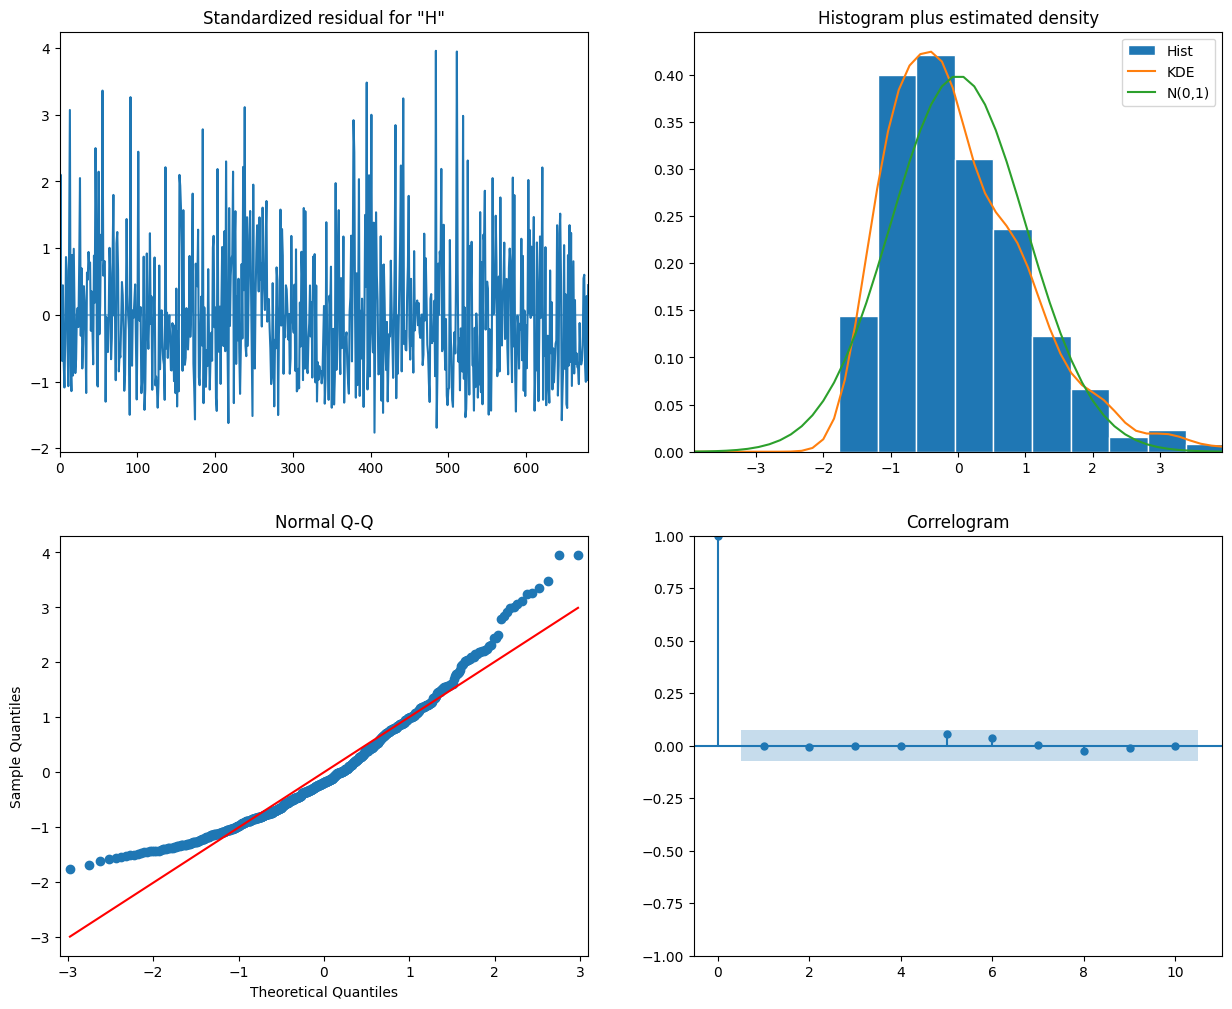

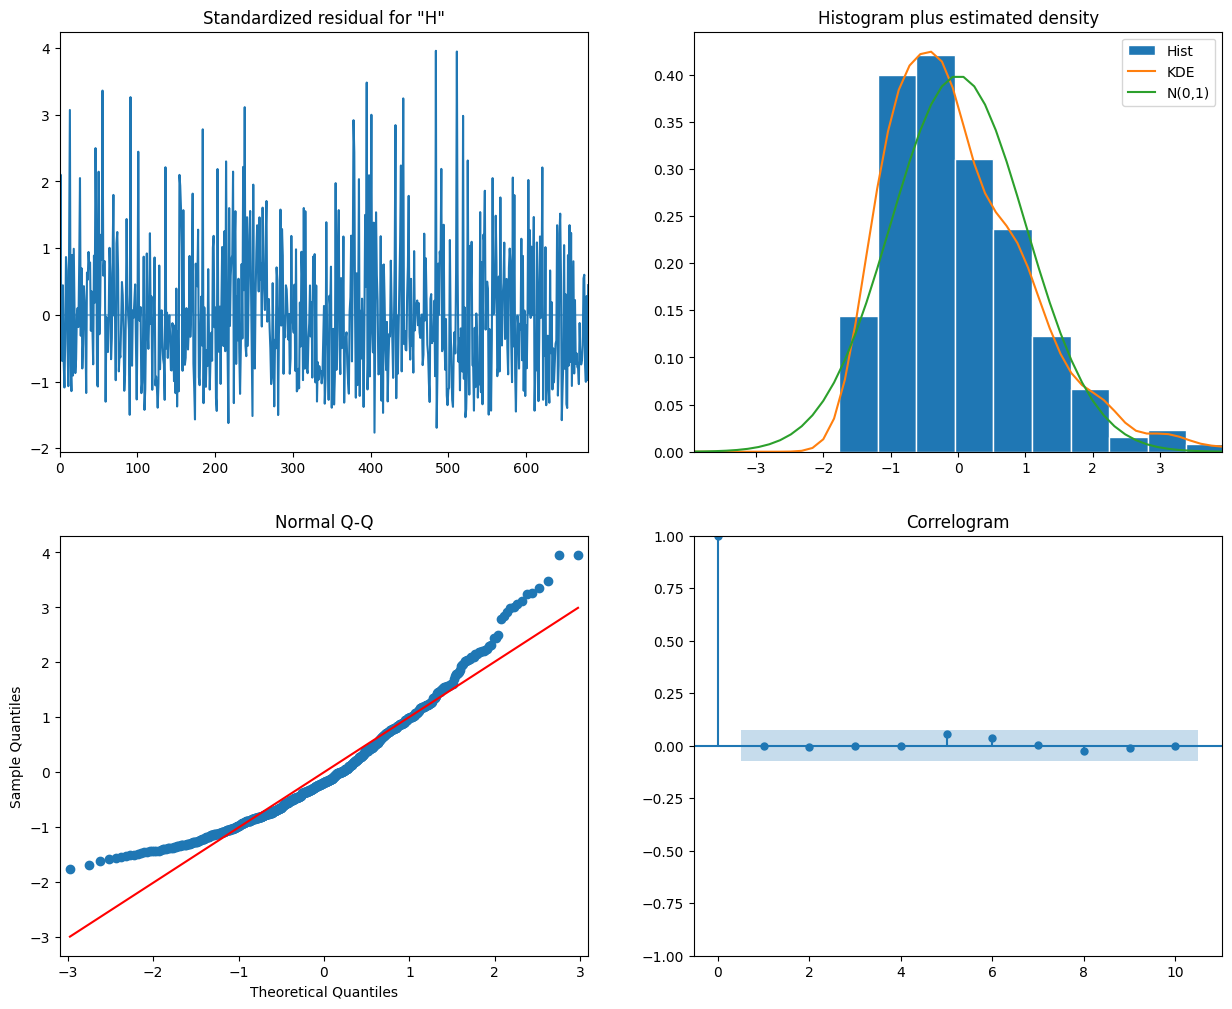

In [19]:
mat_arima_model = auto_arima(train_mat['HCHO_Reading'], seasonal=False, trace=True)
p,d,q = mat_arima_model.order
print(p,d,q)
arima_mat = ARIMA(train_mat['HCHO_Reading'], order=(p,d,q))
arima_fit_mat = arima_mat.fit()
print(arima_fit_mat.summary())
arima_fit_mat.plot_diagnostics(figsize=(15,12))

In [20]:
mat_test_preds_arima = arima_fit_mat.forecast(steps=len(test_mat))
rmse_mat = root_mean_squared_error(test_mat['HCHO_Reading'], mat_test_preds_arima)
print(f'ARIMA RMSE for Matara: {rmse_mat}')
print(mat_test_preds_arima)

ARIMA RMSE for Matara: 7.111808512157832e-05
681    0.000099
682    0.000101
683    0.000101
684    0.000105
685    0.000103
         ...   
847    0.000103
848    0.000103
849    0.000103
850    0.000103
851    0.000103
Name: predicted_mean, Length: 171, dtype: float64


SARIMA

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.52 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-11148.196, Time=0.11 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-10857.264, Time=0.90 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-11146.034, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-10327.011, Time=0.08 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=-10859.492, Time=0.92 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-11146.476, Time=0.88 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-11149.824, Time=0.10 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=-11148.216, Time=1.09 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=-11149.459, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-11147.547, Time=0.31 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-11147.727, Time=0.11 sec
 ARIMA(2,0,1

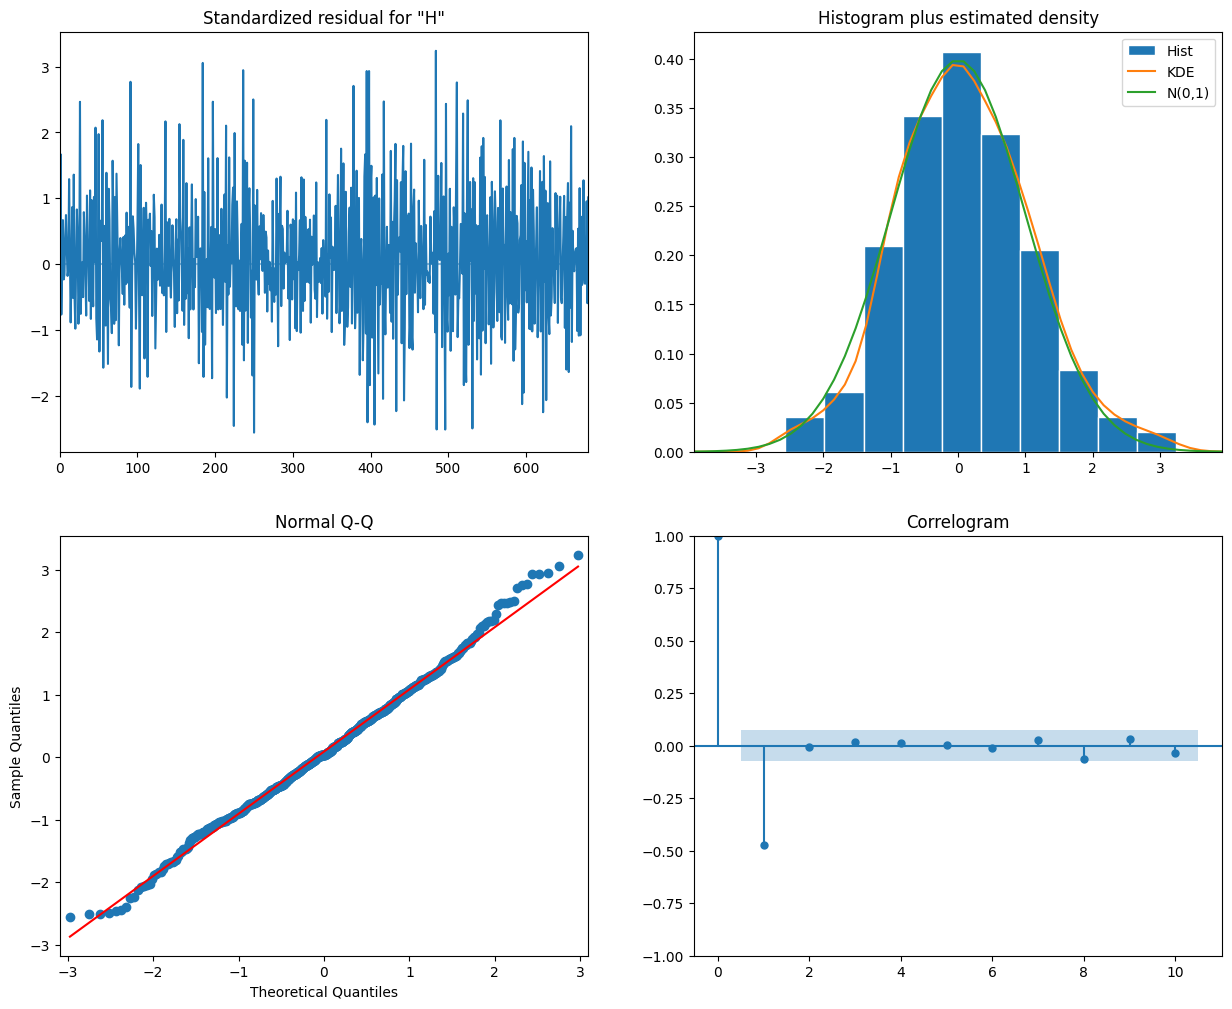

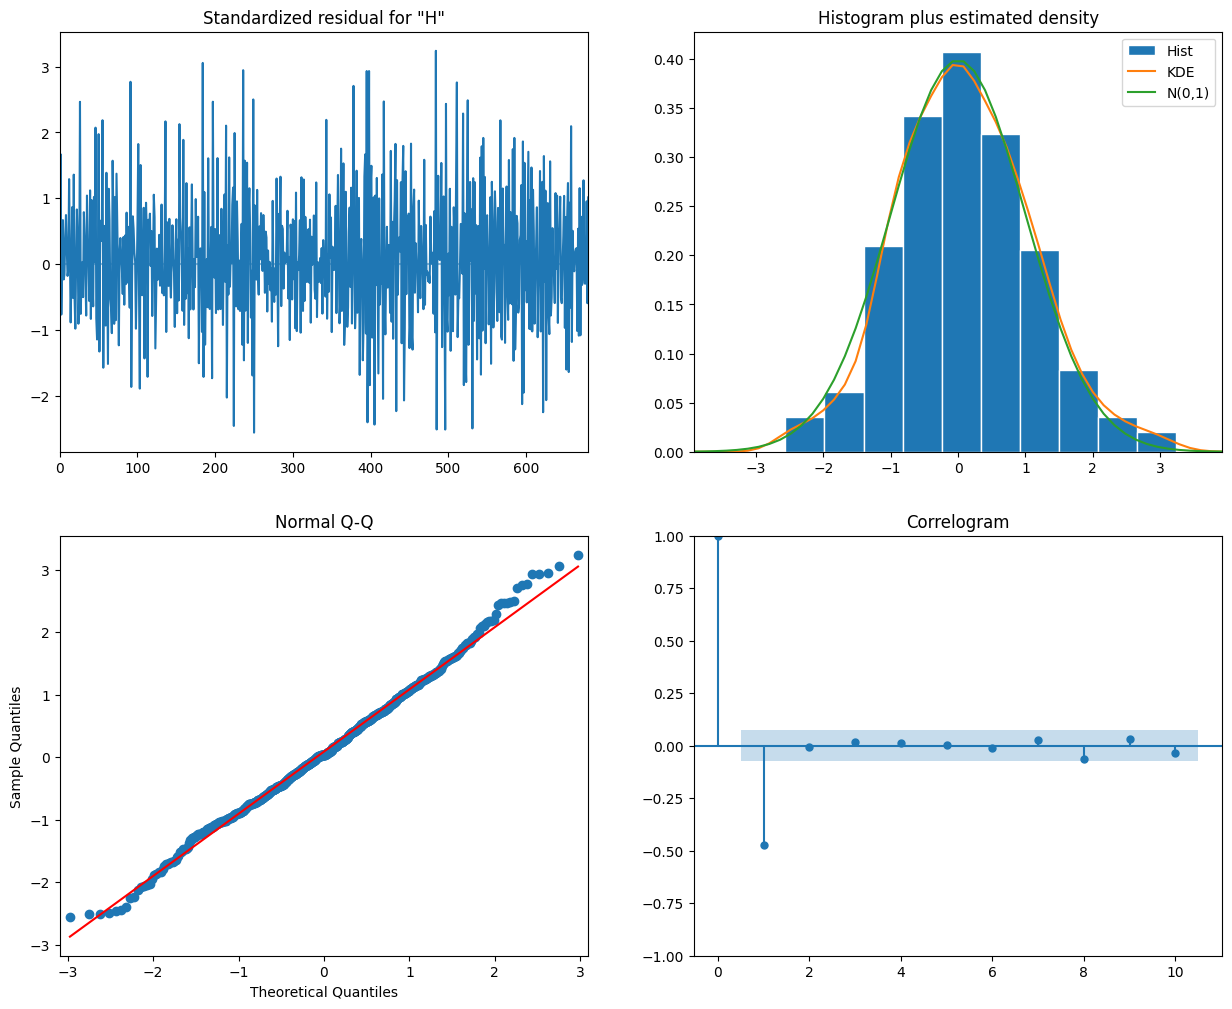

In [21]:
mat_sarima_model = auto_arima(train_mat['HCHO_Reading'], seasonal=True, trace=True, m=12)
p,d,q = mat_sarima_model.order
print(p,d,q)
sarima_mat = SARIMAX(train_mat['HCHO_Reading'], order=(p,d,q), seasonal_order=(p,d,q,12))
sarima_fit_mat = sarima_mat.fit()
print(sarima_fit_mat.summary())
sarima_fit_mat.plot_diagnostics(figsize=(15,12))

In [22]:
mat_test_preds_sarima = sarima_fit_mat.forecast(steps=len(test_mat))
rmse_mat_sarima = root_mean_squared_error(test_mat['HCHO_Reading'], mat_test_preds_sarima)
print(f'SARIMA RMSE for Matara: {rmse_mat_sarima}')
print(mat_test_preds_sarima)

SARIMA RMSE for Matara: 0.00011416792584163858
681    1.331192e-04
682    9.062089e-05
683    6.921579e-05
684    6.178544e-05
685    6.545368e-05
           ...     
847    2.355269e-07
848    7.397671e-07
849    8.061666e-07
850    5.494043e-07
851    4.192280e-07
Name: predicted_mean, Length: 171, dtype: float64


Gaussian Process

In [23]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp_mat = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

gp_mat.fit(train_mat.index.values.reshape(-1,1), train_mat['HCHO_Reading'])

mat_test_preds_gp = gp_mat.predict(test_mat.index.values.reshape(-1,1))
rmse_mat_gp = root_mean_squared_error(test_mat['HCHO_Reading'], mat_test_preds_gp)
print(f'Gaussian Process RMSE for Matara: {rmse_mat_gp}')

Gaussian Process RMSE for Matara: 0.00013609580345579162


## Nuwara Eliya

In [24]:
nuwara_eliya_df = pd.read_csv('nuwara_eliya_df.csv')
nuwara_eliya_df

HCHO_Reading      Location Current_Date
0        0.000191  Nuwara Eliya   2019-01-03
1        0.000051  Nuwara Eliya   2019-01-04
2        0.000065  Nuwara Eliya   2019-01-05
3        0.000090  Nuwara Eliya   2019-01-06
4        0.000041  Nuwara Eliya   2019-01-07
..            ...           ...          ...
632      0.000041  Nuwara Eliya   2023-11-11
633      0.000036  Nuwara Eliya   2023-11-23
634      0.000108  Nuwara Eliya   2023-12-13
635      0.000006  Nuwara Eliya   2023-12-17
636      0.000237  Nuwara Eliya   2023-12-23

[637 rows x 3 columns]

In [25]:
drop_location(nuwara_eliya_df)
nuwara_eliya_df

HCHO_Reading Current_Date
0        0.000191   2019-01-03
1        0.000051   2019-01-04
2        0.000065   2019-01-05
3        0.000090   2019-01-06
4        0.000041   2019-01-07
..            ...          ...
632      0.000041   2023-11-11
633      0.000036   2023-11-23
634      0.000108   2023-12-13
635      0.000006   2023-12-17
636      0.000237   2023-12-23

[637 rows x 2 columns]

In [26]:
convert_to_datetime(nuwara_eliya_df)

HCHO_Reading Current_Date
0        0.000191   2019-01-03
1        0.000051   2019-01-04
2        0.000065   2019-01-05
3        0.000090   2019-01-06
4        0.000041   2019-01-07
..            ...          ...
632      0.000041   2023-11-11
633      0.000036   2023-11-23
634      0.000108   2023-12-13
635      0.000006   2023-12-17
636      0.000237   2023-12-23

[637 rows x 2 columns]

In [27]:
train_size_nuw = int(len(nuwara_eliya_df) * 0.8)
train_nuw, test_nuw = nuwara_eliya_df.iloc[:train_size_nuw], nuwara_eliya_df.iloc[train_size_nuw:]

ARIMA

Performing stepwise search to minimize aic


 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-6377.262, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-7702.477, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-8088.422, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-7878.653, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-8157.577, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-8211.367, Time=0.08 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-8234.319, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-8261.239, Time=0.38 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=-8257.610, Time=0.29 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-8229.630, Time=0.37 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-8329.367, Time=0.93 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-8327.974, Time=0.61 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=-8327.108, Time=0.30 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-8325.726, Time=0.26 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0] intercept
Total fit time:

c:\Users\arkha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:           HCHO_Reading   No. Observations:                  509
Model:                 ARIMA(5, 0, 0)   Log Likelihood                4171.684
Date:                Mon, 15 Apr 2024   AIC                          -8329.368
Time:                        20:03:44   BIC                          -8299.741
Sample:                             0   HQIC                         -8317.752
                                - 509                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   4.13e-06     25.514      0.000    9.72e-05       0.000
ar.L1          0.0734   3.11e-11   2.36e+09      0.000       0.073       0.073
ar.L2         -0.0376   2.15e-11  -1.75e+09      0.0

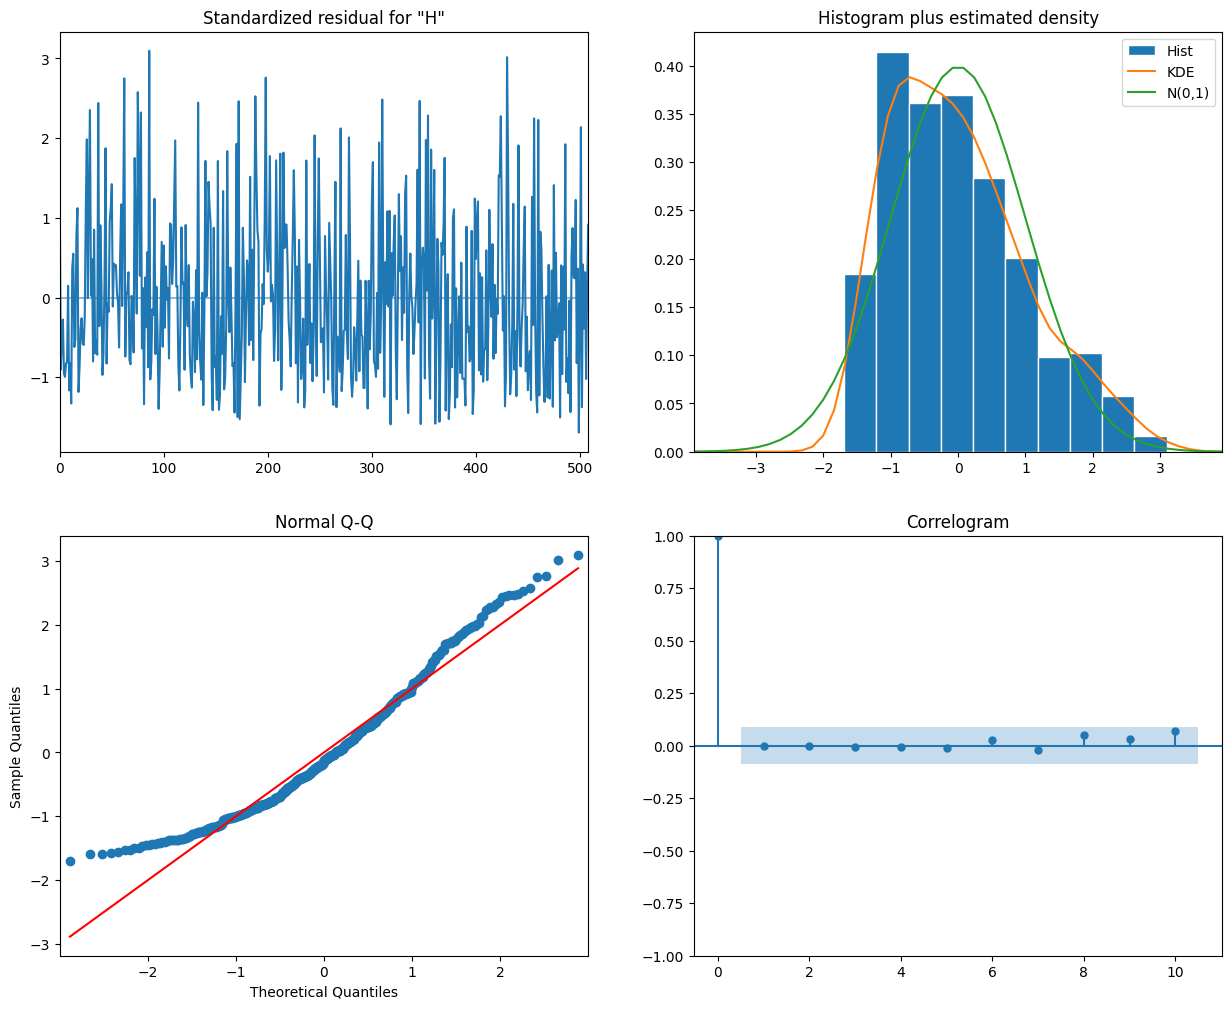

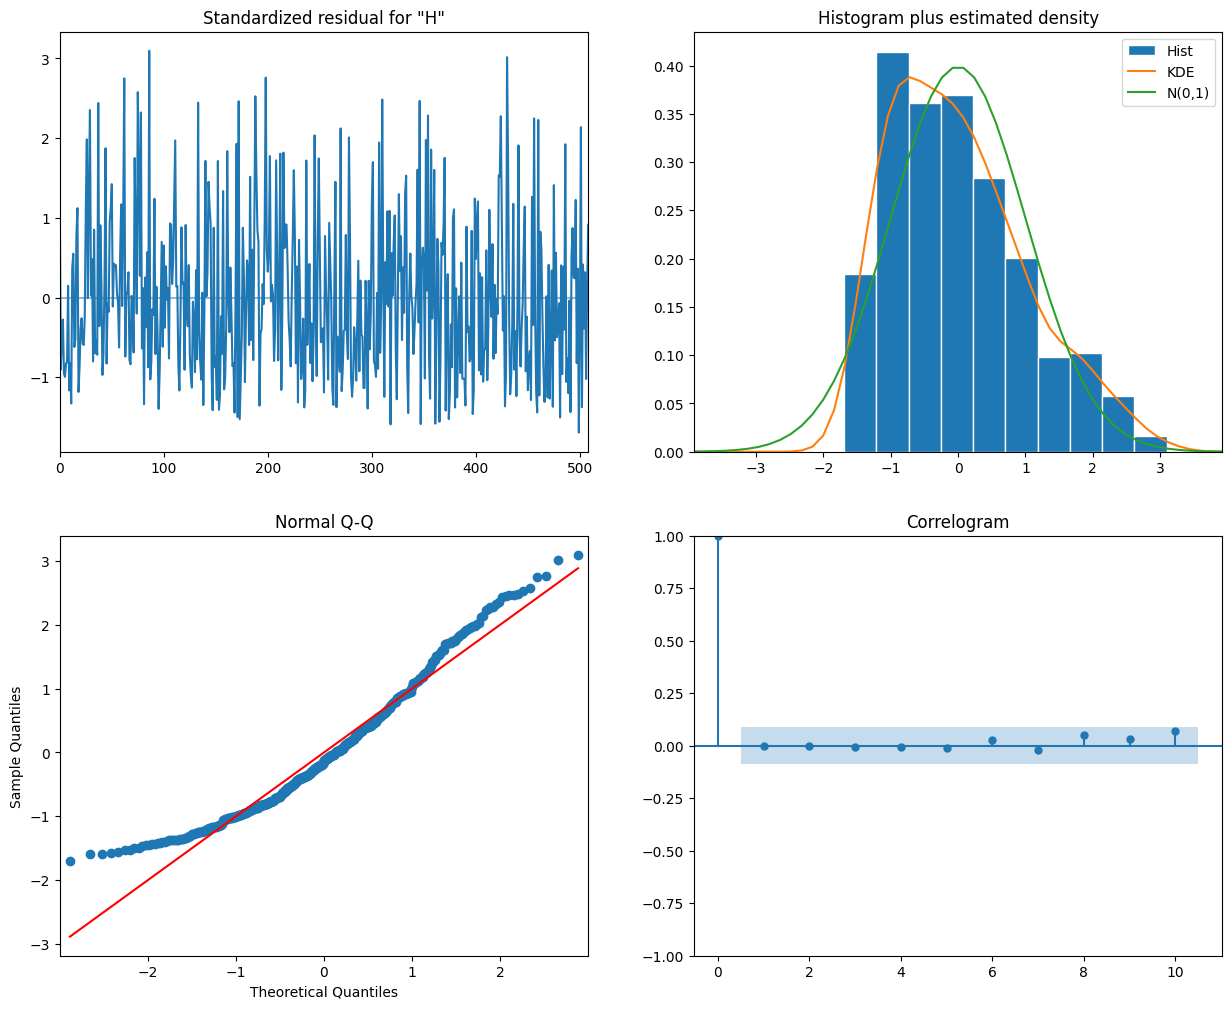

In [28]:
nuw_arima_model = auto_arima(train_nuw['HCHO_Reading'], seasonal=False, trace=True)
p,d,q = nuw_arima_model.order
print(p,d,q)
arima_nuw = ARIMA(train_nuw['HCHO_Reading'], order=(p,d,q))
arima_fit_nuw = arima_nuw.fit()
print(arima_fit_nuw.summary())
arima_fit_nuw.plot_diagnostics(figsize=(15,12))

In [29]:
nuw_test_preds_arima = arima_fit_nuw.forecast(steps=len(test_nuw))
rmse_nuw = root_mean_squared_error(test_nuw['HCHO_Reading'], nuw_test_preds_arima)
print(f'ARIMA RMSE for Nuwara Eliya: {rmse_nuw}')
print(nuw_test_preds_arima)

ARIMA RMSE for Nuwara Eliya: 6.107100852188965e-05
509    0.000106
510    0.000103
511    0.000104
512    0.000106
513    0.000111
         ...   
632    0.000105
633    0.000105
634    0.000105
635    0.000105
636    0.000105
Name: predicted_mean, Length: 128, dtype: float64


SARIMA

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.84 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-8331.581, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-8105.669, Time=0.80 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-8329.462, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-7702.477, Time=0.03 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=-8111.542, Time=0.44 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-8329.227, Time=0.20 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-8332.167, Time=0.10 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=-8329.605, Time=0.31 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=-8330.645, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-8330.150, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-8331.953, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[12

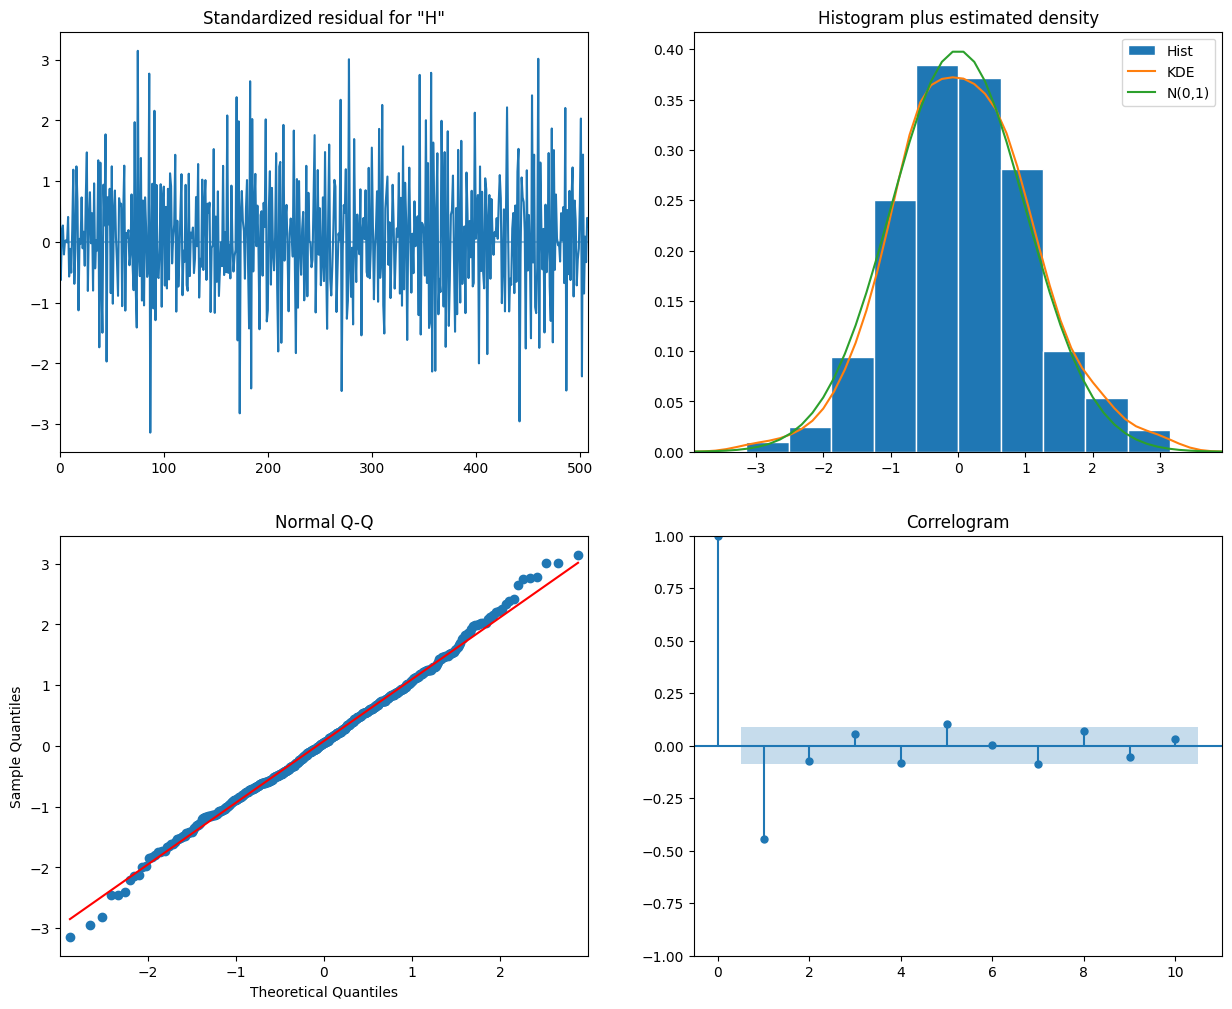

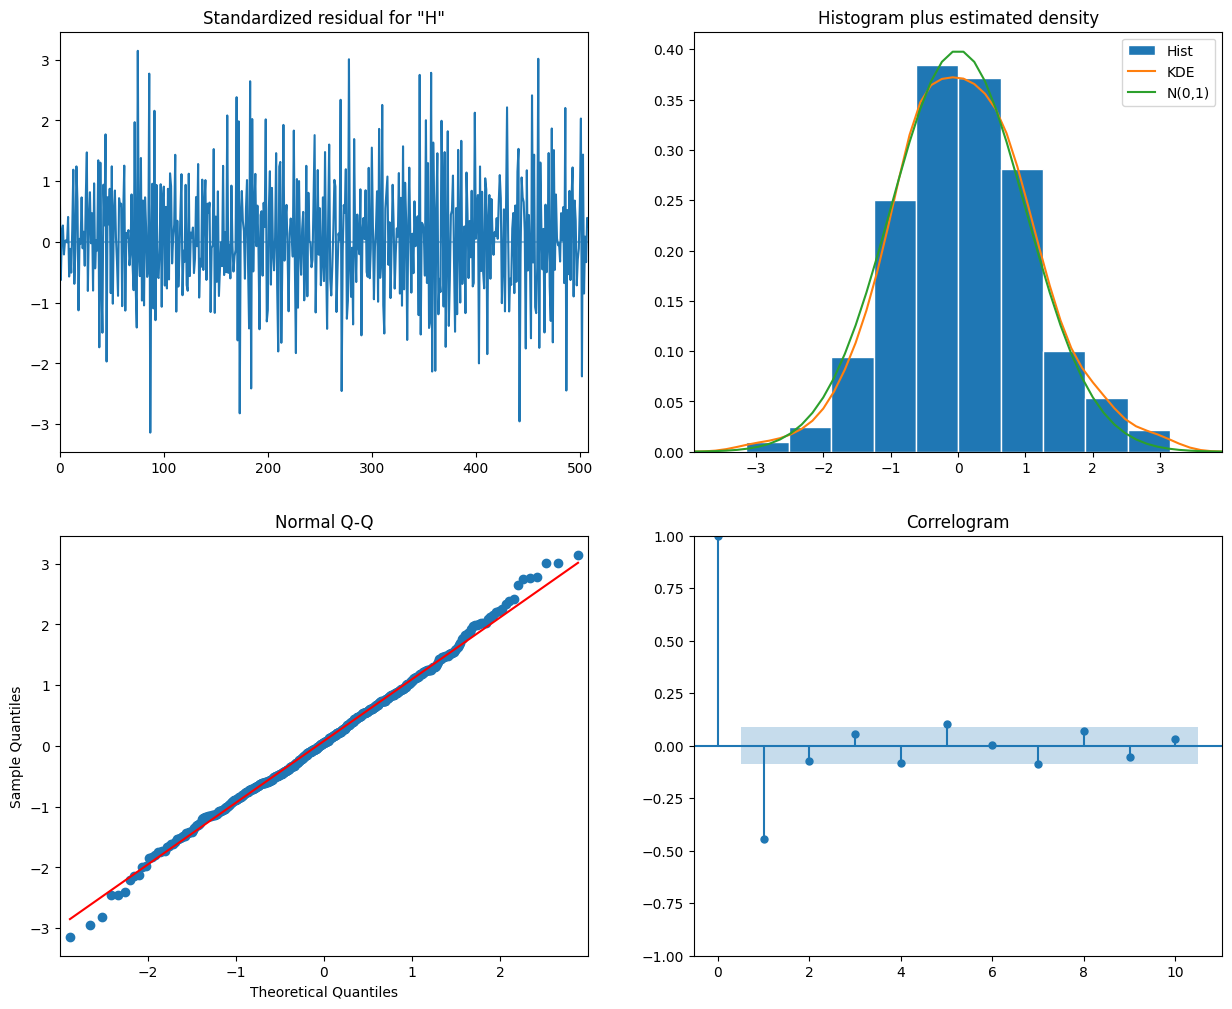

In [30]:
nuw_sarima_model = auto_arima(train_nuw['HCHO_Reading'], seasonal=True, trace=True, m=12)
p,d,q = nuw_sarima_model.order
print(p,d,q)
sarima_nuw = SARIMAX(train_nuw['HCHO_Reading'], order=(p,d,q), seasonal_order=(p,d,q,12))
sarima_fit_nuw = sarima_nuw.fit()
print(sarima_fit_nuw.summary())
sarima_fit_nuw.plot_diagnostics(figsize=(15,12))

In [31]:
nuw_test_preds_sarima = sarima_fit_nuw.forecast(steps=len(test_nuw))
rmse_nuw_sarima = root_mean_squared_error(test_nuw['HCHO_Reading'], nuw_test_preds_sarima)
print(f'SARIMA RMSE for Nuwara Eliya: {rmse_nuw_sarima}')
print(nuw_test_preds_sarima)

SARIMA RMSE for Nuwara Eliya: 9.924966409214873e-05
509    7.011867e-05
510    1.124371e-04
511    1.556417e-05
512    6.115693e-05
513    1.910263e-04
           ...     
632    2.106150e-06
633    6.548455e-06
634    6.334534e-07
635    3.079601e-06
636    2.123507e-06
Name: predicted_mean, Length: 128, dtype: float64


Gaussian Process

In [32]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp_nuw = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

gp_nuw.fit(train_nuw.index.values.reshape(-1,1), train_nuw['HCHO_Reading'])

nuw_test_preds_gp = gp_nuw.predict(test_nuw.index.values.reshape(-1,1))
rmse_nuw_gp = root_mean_squared_error(test_nuw['HCHO_Reading'], nuw_test_preds_gp)
print(f'Gaussian Process RMSE for Nuwara Eliya: {rmse_nuw_gp}')

Gaussian Process RMSE for Nuwara Eliya: 0.0006302386407343985


## Kandy

In [33]:
kandy_df = pd.read_csv('kandy_df.csv')
kandy_df

HCHO_Reading Location Current_Date
0        0.000176    Kandy   2019-01-01
1        0.000092    Kandy   2019-01-02
2        0.000191    Kandy   2019-01-04
3        0.000122    Kandy   2019-01-05
4        0.000163    Kandy   2019-01-07
..            ...      ...          ...
913      0.000116    Kandy   2023-12-07
914      0.000261    Kandy   2023-12-11
915      0.000114    Kandy   2023-12-21
916      0.000116    Kandy   2023-12-23
917      0.000056    Kandy   2023-12-30

[918 rows x 3 columns]

In [34]:
drop_location(kandy_df)
kandy_df

HCHO_Reading Current_Date
0        0.000176   2019-01-01
1        0.000092   2019-01-02
2        0.000191   2019-01-04
3        0.000122   2019-01-05
4        0.000163   2019-01-07
..            ...          ...
913      0.000116   2023-12-07
914      0.000261   2023-12-11
915      0.000114   2023-12-21
916      0.000116   2023-12-23
917      0.000056   2023-12-30

[918 rows x 2 columns]

In [35]:
convert_to_datetime(kandy_df)

HCHO_Reading Current_Date
0        0.000176   2019-01-01
1        0.000092   2019-01-02
2        0.000191   2019-01-04
3        0.000122   2019-01-05
4        0.000163   2019-01-07
..            ...          ...
913      0.000116   2023-12-07
914      0.000261   2023-12-11
915      0.000114   2023-12-21
916      0.000116   2023-12-23
917      0.000056   2023-12-30

[918 rows x 2 columns]

In [36]:
# Handle NaN values
kandy_df.dropna(inplace=True)  # Remove rows with NaN values

In [37]:
kandy_df.isnull().sum()

HCHO_Reading    0
Current_Date    0
dtype: int64

In [38]:
import numpy as np
infinity_vals = np.isinf(kandy_df).sum()
print(infinity_vals)

HCHO_Reading    0
Current_Date    0
dtype: int64


In [39]:
train_size_kan = int(len(kandy_df) * 0.8)
train_kan, test_kan = kandy_df.iloc[:train_size_kan], kandy_df.iloc[train_size_kan:]

ARIMA

In [40]:
# kan_arima_model = auto_arima(train_kan['HCHO_Reading'], seasonal=True, trace=True)
# p,d,q = kan_arima_model.order
# print(p,d,q)
# arima_kan = ARIMA(train_kan['HCHO_Reading'], order=(p,d,q))
# print(train_kan)
# arima_fit_kan = arima_kan.fit()
# print(arima_fit_kan.summary())
# arima_fit_kan.plot_diagnostics(figsize=(15,12))

In [41]:
# kan_test_preds_arima = arima_fit_kan.forecast(steps=len(test_kan))
# rmse_kan = root_mean_squared_error(test_kan['HCHO_Reading'], kan_test_preds_arima)
# print(f'ARIMA RMSE for Kandy: {rmse_kan}')
# print(kan_test_preds_arima)

SARIMA

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-11931.240, Time=1.96 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-11585.514, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-11722.128, Time=0.50 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-11858.081, Time=1.72 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-11587.536, Time=0.12 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-11933.258, Time=2.02 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-11934.812, Time=0.58 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-11933.273, Time=1.91 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=-11932.389, Time=0.68 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=-11874.473, Time=1.55 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=-11533.552, Time=0.81 sec
 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=-11928.764, Time=0.70 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-11889.489, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[12] intercept   : AIC=-11935.892, Time=0.56 sec
 ARIMA(1,1,3)(1,0,0)[12] intercept

c:\Users\arkha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                       HCHO_Reading   No. Observations:                  734
Model:             SARIMAX(0, 1, 3)x(0, 1, 3, 12)   Log Likelihood                5815.966
Date:                            Mon, 15 Apr 2024   AIC                         -11617.933
Time:                                    20:04:40   BIC                         -11585.868
Sample:                                         0   HQIC                        -11605.555
                                            - 734                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7309   7.43e-19  -9.84e+17      0.000      -0.731      -0.731
ma.L2         -0.1472   5.94e-19  -

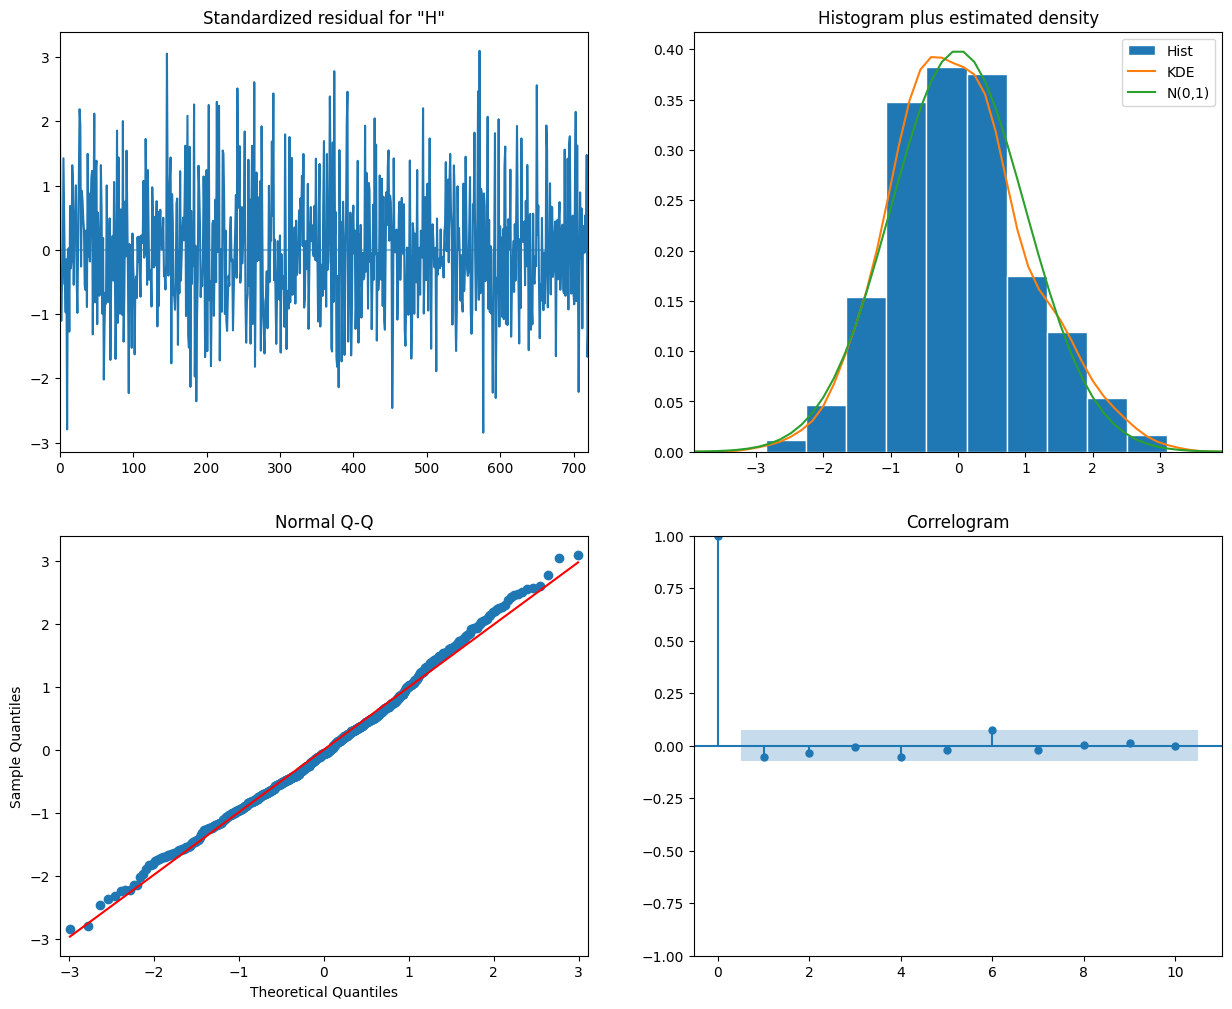

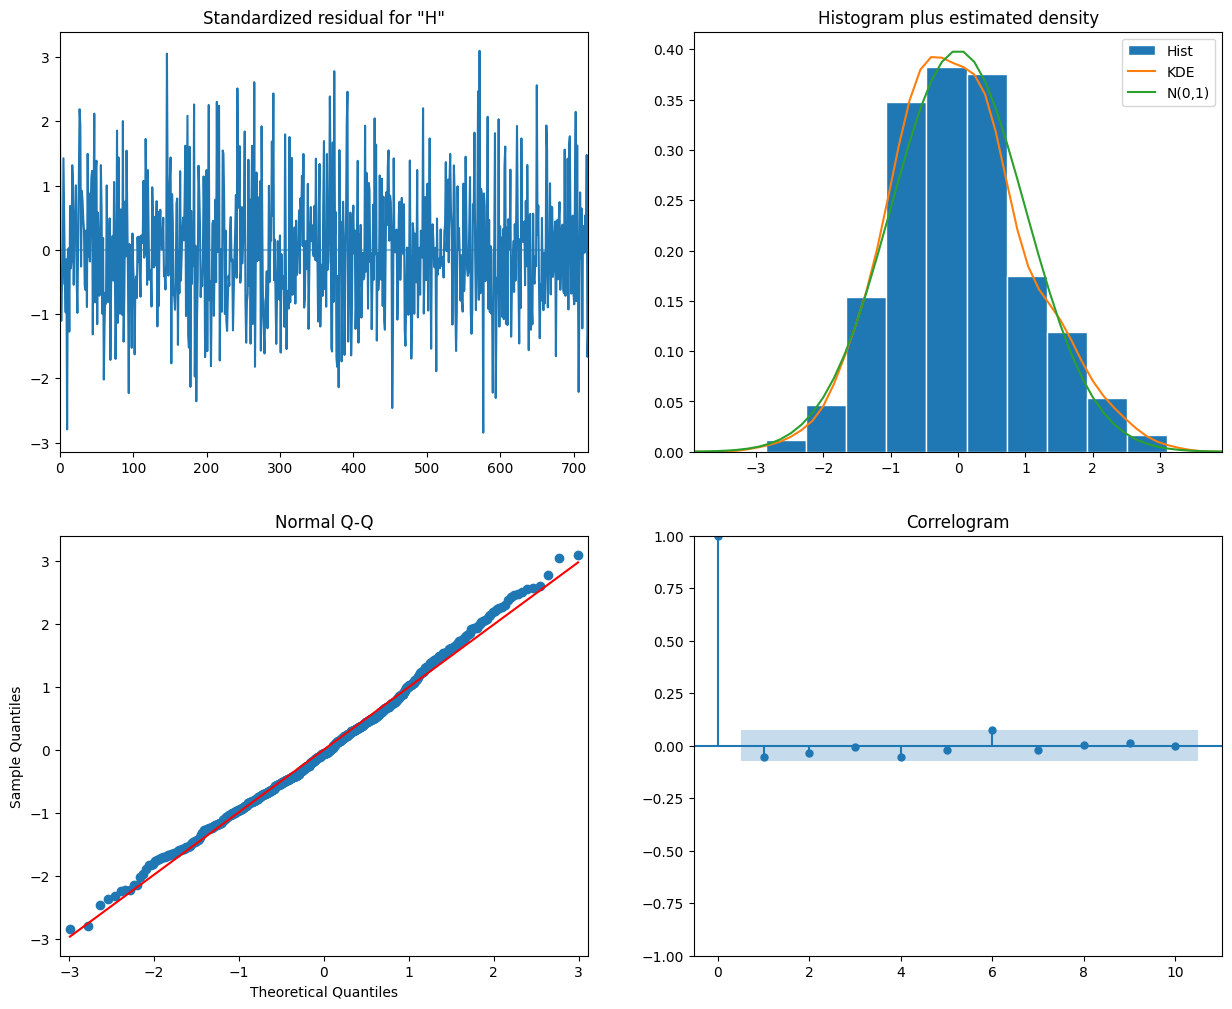

In [42]:
kan_sarima_model = auto_arima(train_kan['HCHO_Reading'], seasonal=True, trace=True, m=12)
p,d,q = kan_sarima_model.order
print(p,d,q)
sarima_kan = SARIMAX(train_kan['HCHO_Reading'], order=(p,d,q), seasonal_order=(p,d,q,12))
sarima_fit_kan = sarima_kan.fit()
print(sarima_fit_kan.summary())
sarima_fit_kan.plot_diagnostics(figsize=(15,12))

In [43]:
kan_test_preds_sarima = sarima_fit_kan.forecast(steps=len(test_kan))
rmse_kan_sarima = root_mean_squared_error(test_kan['HCHO_Reading'], kan_test_preds_sarima)
print(f'SARIMA RMSE for Kandy: {rmse_kan_sarima}')
print(kan_test_preds_sarima)

SARIMA RMSE for Kandy: 8.449819715528255e-05
734    0.000106
735    0.000142
736    0.000131
737    0.000121
738    0.000085
         ...   
913    0.000153
914    0.000177
915    0.000204
916    0.000193
917    0.000184
Name: predicted_mean, Length: 184, dtype: float64


Gaussian Process

In [44]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp_kan = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

gp_kan.fit(train_kan.index.values.reshape(-1,1), train_kan['HCHO_Reading'])

kan_test_preds_gp = gp_kan.predict(test_kan.index.values.reshape(-1,1))
rmse_kan_gp = root_mean_squared_error(test_kan['HCHO_Reading'], kan_test_preds_gp)
print(f'Gaussian Process RMSE for Kandy: {rmse_kan_gp}')

Gaussian Process RMSE for Kandy: 0.0001471778020924947


## Monaragala

In [45]:
monaragala_df = pd.read_csv('monaragala_df.csv')
monaragala_df

HCHO_Reading    Location Current_Date
0         0.000019  Monaragala   2019-01-02
1         0.000028  Monaragala   2019-01-03
2         0.000037  Monaragala   2019-01-04
3         0.000146  Monaragala   2019-01-06
4         0.000028  Monaragala   2019-01-07
...            ...         ...          ...
1034      0.000140  Monaragala   2023-12-11
1035      0.000188  Monaragala   2023-12-14
1036      0.000052  Monaragala   2023-12-18
1037      0.000149  Monaragala   2023-12-23
1038      0.000031  Monaragala   2023-12-25

[1039 rows x 3 columns]

In [46]:
drop_location(monaragala_df)
monaragala_df

HCHO_Reading Current_Date
0         0.000019   2019-01-02
1         0.000028   2019-01-03
2         0.000037   2019-01-04
3         0.000146   2019-01-06
4         0.000028   2019-01-07
...            ...          ...
1034      0.000140   2023-12-11
1035      0.000188   2023-12-14
1036      0.000052   2023-12-18
1037      0.000149   2023-12-23
1038      0.000031   2023-12-25

[1039 rows x 2 columns]

In [47]:
convert_to_datetime(monaragala_df)

HCHO_Reading Current_Date
0         0.000019   2019-01-02
1         0.000028   2019-01-03
2         0.000037   2019-01-04
3         0.000146   2019-01-06
4         0.000028   2019-01-07
...            ...          ...
1034      0.000140   2023-12-11
1035      0.000188   2023-12-14
1036      0.000052   2023-12-18
1037      0.000149   2023-12-23
1038      0.000031   2023-12-25

[1039 rows x 2 columns]

In [48]:
train_size_mon = int(len(monaragala_df) * 0.8)
train_mon, test_mon = monaragala_df.iloc[:train_size_mon], monaragala_df.iloc[train_size_mon:]

ARIMA

Performing stepwise search to minimize aic


 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-13468.419, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-12227.199, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-13142.294, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-12562.357, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-13467.339, Time=0.36 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-13429.577, Time=0.58 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-13241.786, Time=1.76 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-13481.014, Time=0.46 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-12865.032, Time=0.50 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-12215.193, Time=0.54 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-13168.560, Time=0.75 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-11267.932, Time=0.90 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=-13496.736, Time=0.59 sec
 ARIMA(4,0,4)(0,0,0)[0]             : AIC=-13506.784, Time=0.72 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=-12213

c:\Users\arkha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:           HCHO_Reading   No. Observations:                  831
Model:                 ARIMA(3, 0, 3)   Log Likelihood                6514.499
Date:                Mon, 15 Apr 2024   AIC                         -13012.998
Time:                        20:05:07   BIC                         -12975.217
Sample:                             0   HQIC                        -12998.511
                                - 831                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   1.75e-05      7.736      0.000       0.000       0.000
ar.L1          0.0231      0.003      8.295      0.000       0.018       0.029
ar.L2         -0.1406      0.003    -47.072      0.0

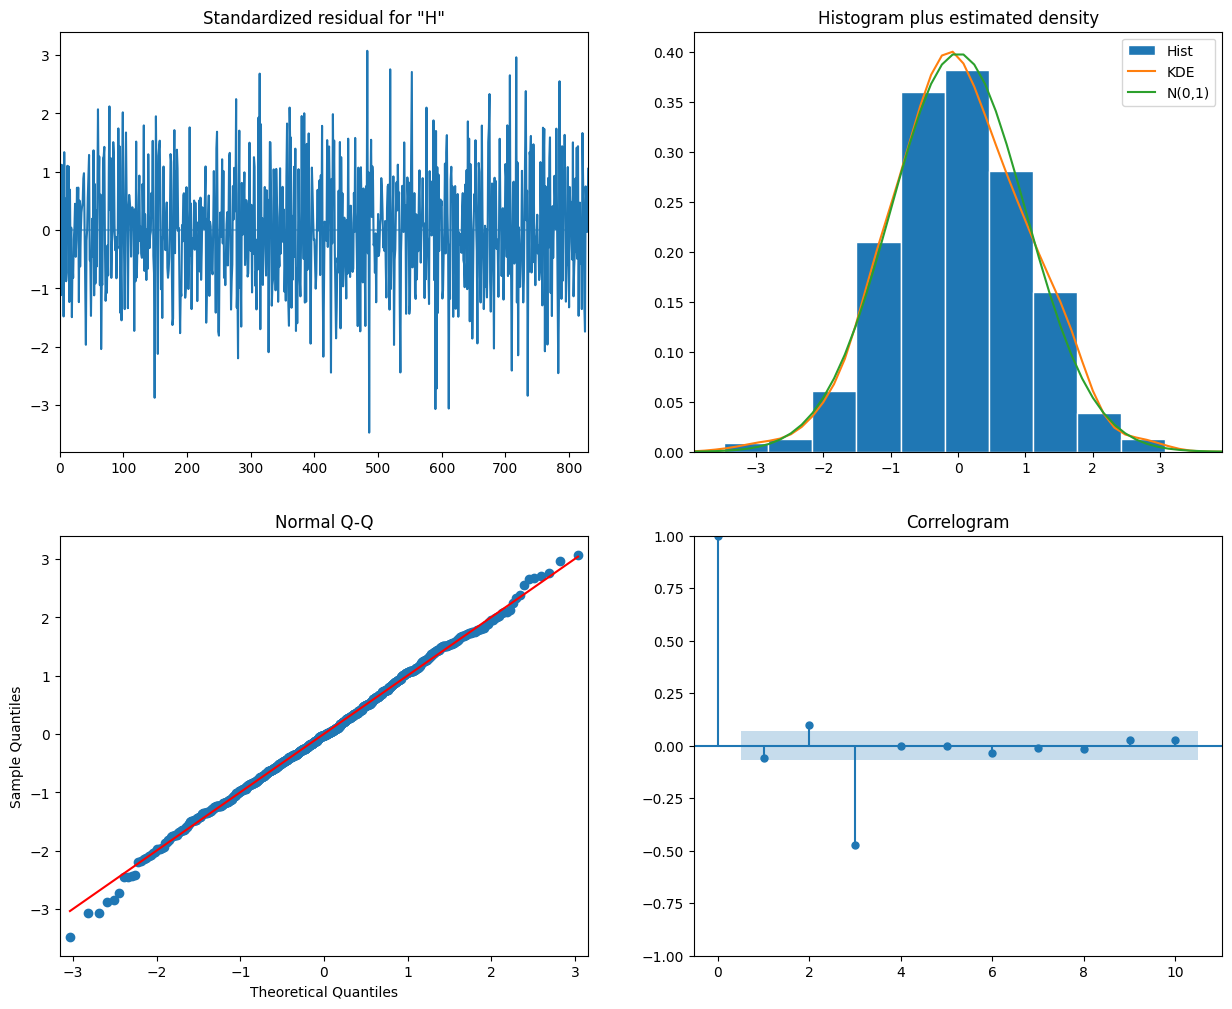

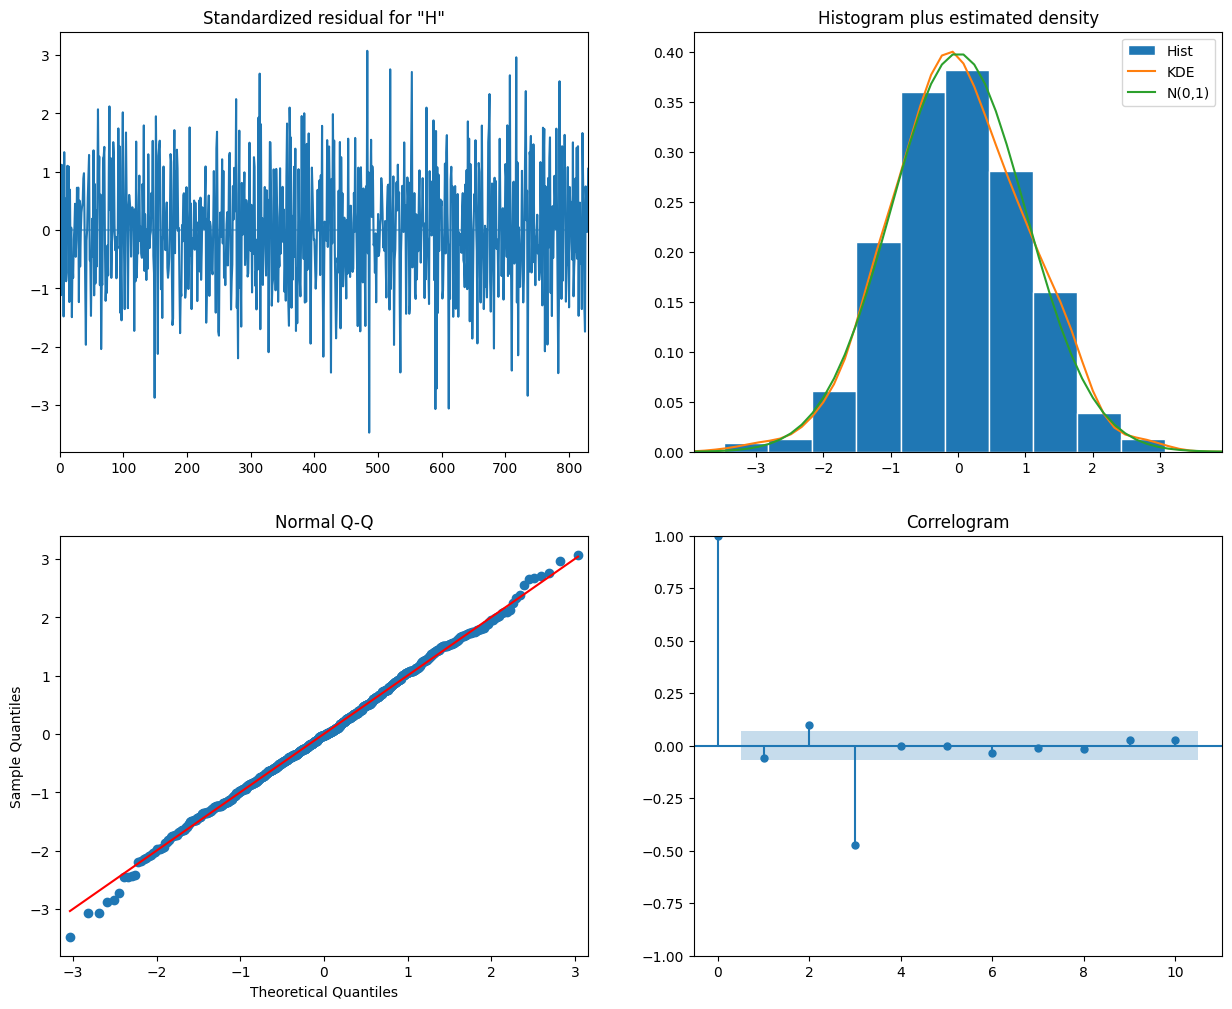

In [49]:
mon_arima_model = auto_arima(train_mon['HCHO_Reading'], seasonal=False, trace=True)
p,d,q = mon_arima_model.order
print(p,d,q)
arima_mon = ARIMA(train_mon['HCHO_Reading'], order=(p,d,q))
arima_fit_mon = arima_mon.fit()
print(arima_fit_mon.summary())
arima_fit_mon.plot_diagnostics(figsize=(15,12))

In [50]:
mon_test_preds_arima = arima_fit_mon.forecast(steps=len(test_mon))
rmse_mon_arima = root_mean_squared_error(test_mon['HCHO_Reading'], mon_test_preds_arima)
print(f'ARIMA RMSE for Monaragala: {rmse_mon_arima}')
print(mon_test_preds_arima)

ARIMA RMSE for Monaragala: 9.189649590635338e-05
831     0.000089
832     0.000157
833     0.000234
834     0.000091
835     0.000140
          ...   
1034    0.000079
1035    0.000168
1036    0.000160
1037    0.000079
1038    0.000161
Name: predicted_mean, Length: 208, dtype: float64


SARIMA

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-13407.296, Time=4.62 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-13459.057, Time=0.11 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-13147.479, Time=1.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-13477.291, Time=1.05 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-12227.199, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-13469.724, Time=0.47 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-13323.023, Time=3.29 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-13500.313, Time=2.68 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=-13422.608, Time=6.59 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=-13492.168, Time=2.11 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=-13516.290, Time=2.81 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-13497.705, Time=1.10 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=-13417.558, Time=7.14 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-13160.110, Time=

c:\Users\arkha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                       HCHO_Reading   No. Observations:                  831
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 12)   Log Likelihood                6567.874
Date:                            Mon, 15 Apr 2024   AIC                         -13125.747
Time:                                    20:06:19   BIC                         -13102.134
Sample:                                         0   HQIC                        -13116.692
                                            - 831                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4532   1.48e-18   3.06e+17      0.000       0.453       0.453
ar.L2          0.4476   1.38e-18   

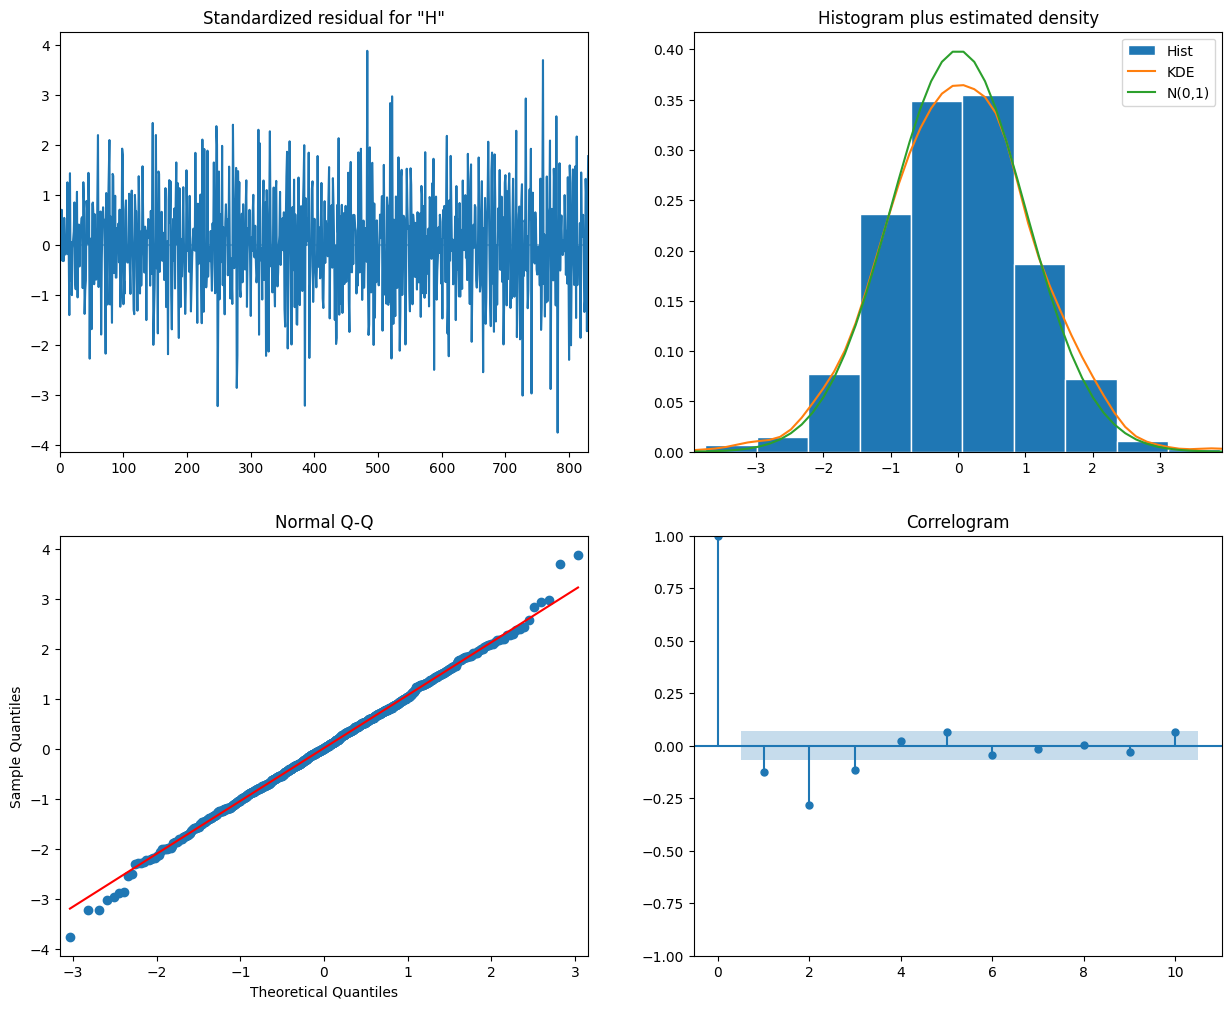

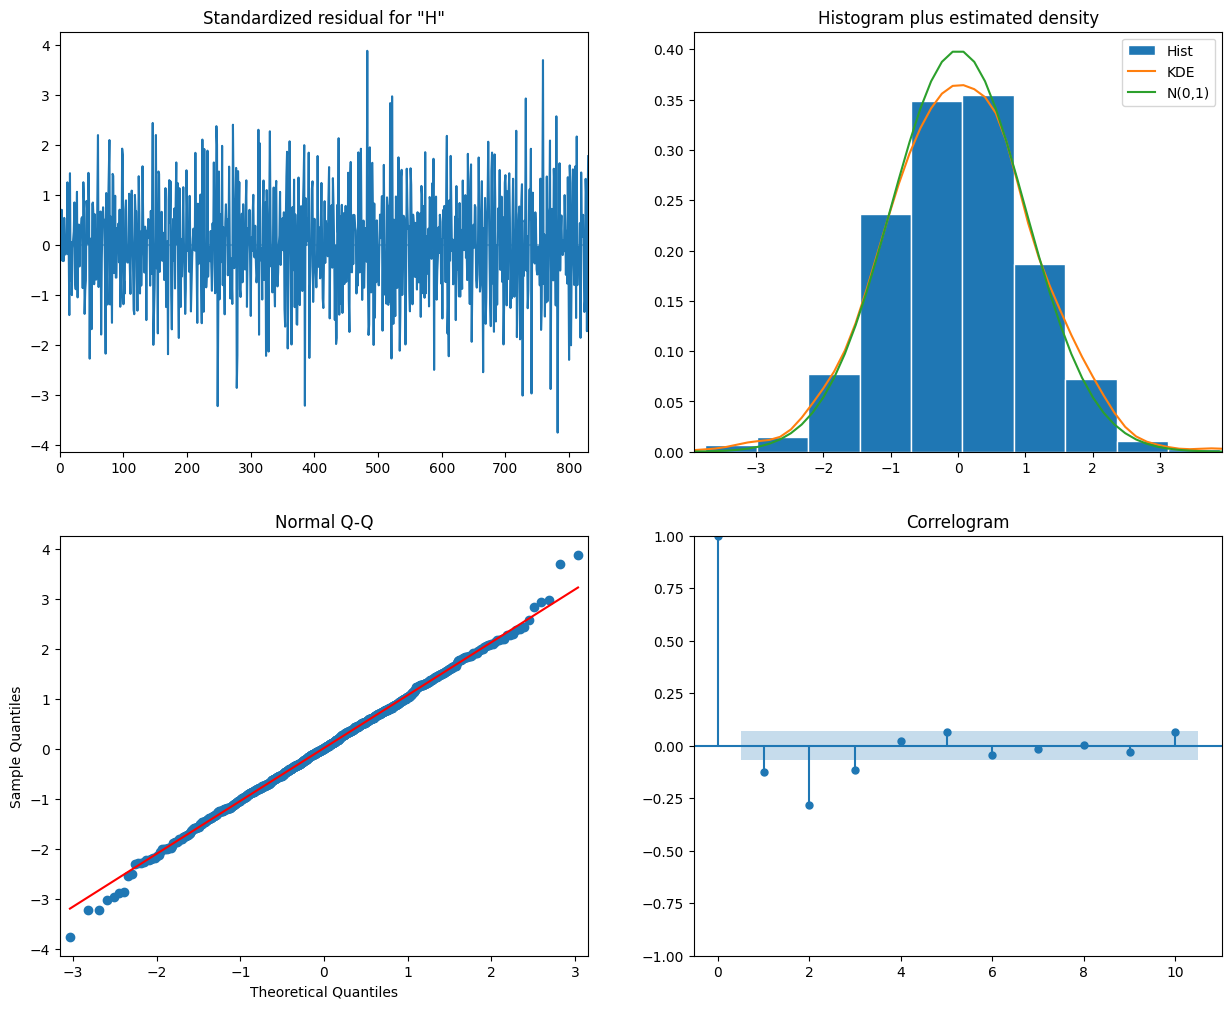

In [51]:
mon_sarima_model = auto_arima(train_mon['HCHO_Reading'], seasonal=True, trace=True, m=12)
p,d,q = mon_sarima_model.order
print(p,d,q)
sarima_mon = SARIMAX(train_mon['HCHO_Reading'], order=(p,d,q), seasonal_order=(p,d,q,12))
sarima_fit_mon = sarima_mon.fit()
print(sarima_fit_mon.summary())
sarima_fit_mon.plot_diagnostics(figsize=(15,12))

In [52]:
mon_test_preds_sarima = sarima_fit_mon.forecast(steps=len(test_mon))
rmse_mon_sarima = root_mean_squared_error(test_mon['HCHO_Reading'], mon_test_preds_sarima)
print(f'SARIMA RMSE for Monaragala: {rmse_mon_sarima}')
print(mon_test_preds_sarima)

SARIMA RMSE for Monaragala: 0.00010105765954929534
831     0.000193
832     0.000141
833     0.000231
834     0.000278
835     0.000111
          ...   
1034    0.000074
1035    0.000077
1036    0.000054
1037    0.000089
1038    0.000104
Name: predicted_mean, Length: 208, dtype: float64


Gaussian Process

In [53]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp_mon = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

gp_mon.fit(train_mon.index.values.reshape(-1,1), train_mon['HCHO_Reading'])

mon_test_preds_gp = gp_mon.predict(test_mon.index.values.reshape(-1,1))
rmse_mon_gp = root_mean_squared_error(test_mon['HCHO_Reading'], mon_test_preds_gp)
print(f'Gaussian Process RMSE for Monaragala: {rmse_mon_gp}')

Gaussian Process RMSE for Monaragala: 0.00019962208513443747


## Kurunegala

In [54]:
kurunegala_df = pd.read_csv('kurunegala_df.csv')
kurunegala_df

HCHO_Reading    Location Current_Date
0         0.000088  Kurunegala   2019-01-01
1         0.000137  Kurunegala   2019-01-02
2         0.000148  Kurunegala   2019-01-03
3         0.000249  Kurunegala   2019-01-05
4         0.000102  Kurunegala   2019-01-06
...            ...         ...          ...
1161      0.000063  Kurunegala   2023-12-23
1162      0.000094  Kurunegala   2023-12-25
1163      0.000152  Kurunegala   2023-12-26
1164      0.000075  Kurunegala   2023-12-27
1165      0.000158  Kurunegala   2023-12-30

[1166 rows x 3 columns]

In [55]:
drop_location(kurunegala_df)
kurunegala_df

HCHO_Reading Current_Date
0         0.000088   2019-01-01
1         0.000137   2019-01-02
2         0.000148   2019-01-03
3         0.000249   2019-01-05
4         0.000102   2019-01-06
...            ...          ...
1161      0.000063   2023-12-23
1162      0.000094   2023-12-25
1163      0.000152   2023-12-26
1164      0.000075   2023-12-27
1165      0.000158   2023-12-30

[1166 rows x 2 columns]

In [56]:
convert_to_datetime(kurunegala_df)

HCHO_Reading Current_Date
0         0.000088   2019-01-01
1         0.000137   2019-01-02
2         0.000148   2019-01-03
3         0.000249   2019-01-05
4         0.000102   2019-01-06
...            ...          ...
1161      0.000063   2023-12-23
1162      0.000094   2023-12-25
1163      0.000152   2023-12-26
1164      0.000075   2023-12-27
1165      0.000158   2023-12-30

[1166 rows x 2 columns]

In [57]:
train_size_kur = int(len(kurunegala_df) * 0.8)
train_kur, test_kur = kurunegala_df.iloc[:train_size_kur], kurunegala_df.iloc[train_size_kur:]

ARIMA

Performing stepwise search to minimize aic


 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-15138.005, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-13654.443, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-14779.722, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-14066.157, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-15127.006, Time=0.41 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-14841.397, Time=0.52 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-15133.050, Time=0.51 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-15147.574, Time=0.56 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-15135.093, Time=0.39 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-15149.713, Time=0.65 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=-15117.564, Time=0.30 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=-15161.942, Time=0.32 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-15145.489, Time=0.45 sec
 ARIMA(4,0,4)(0,0,0)[0]             : AIC=-15148.049, Time=0.71 sec
 ARIMA(3,0,5)(0,0,0)[0]             : AIC=-15145

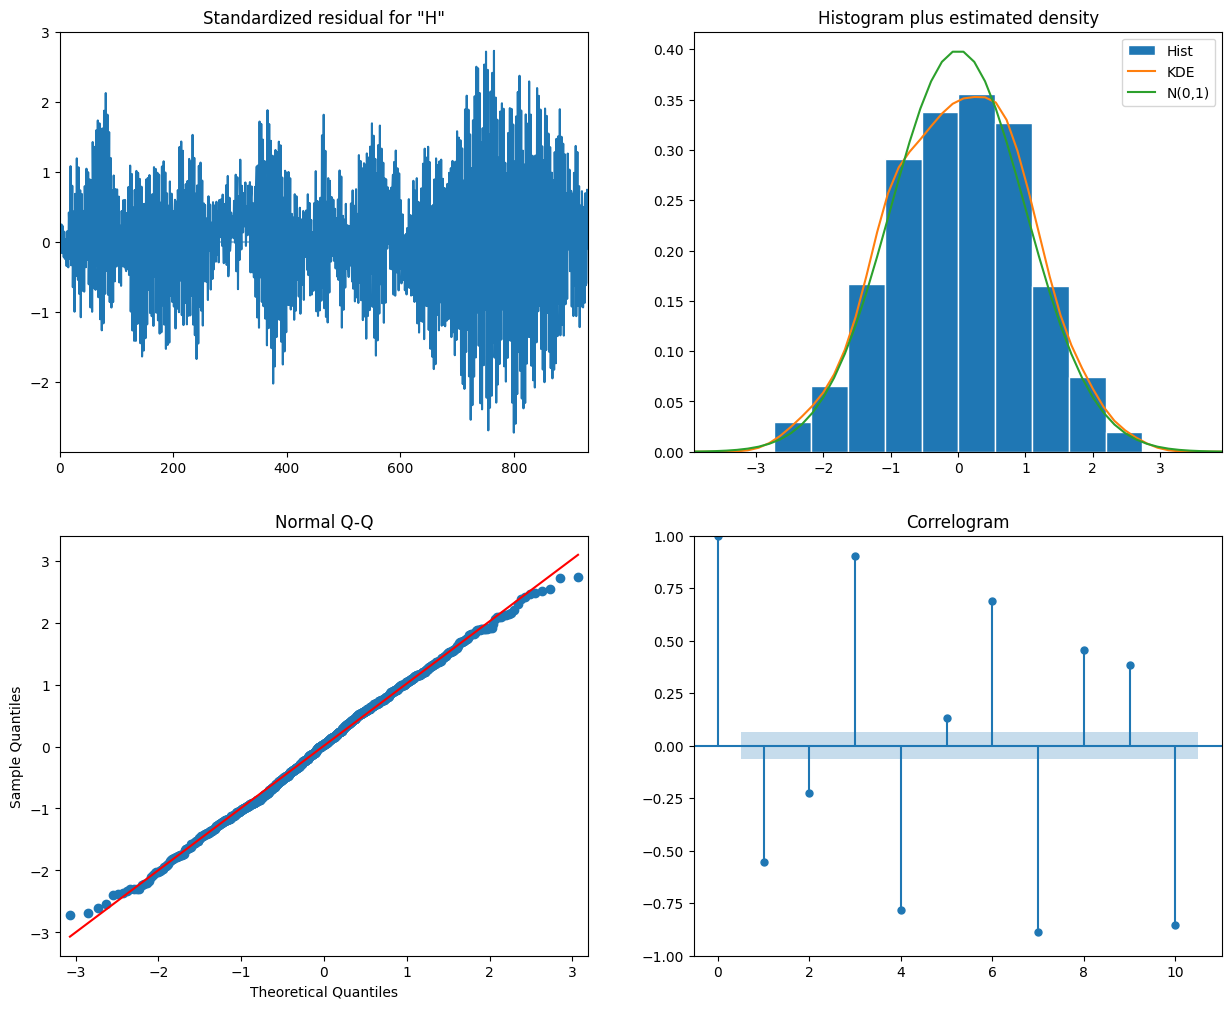

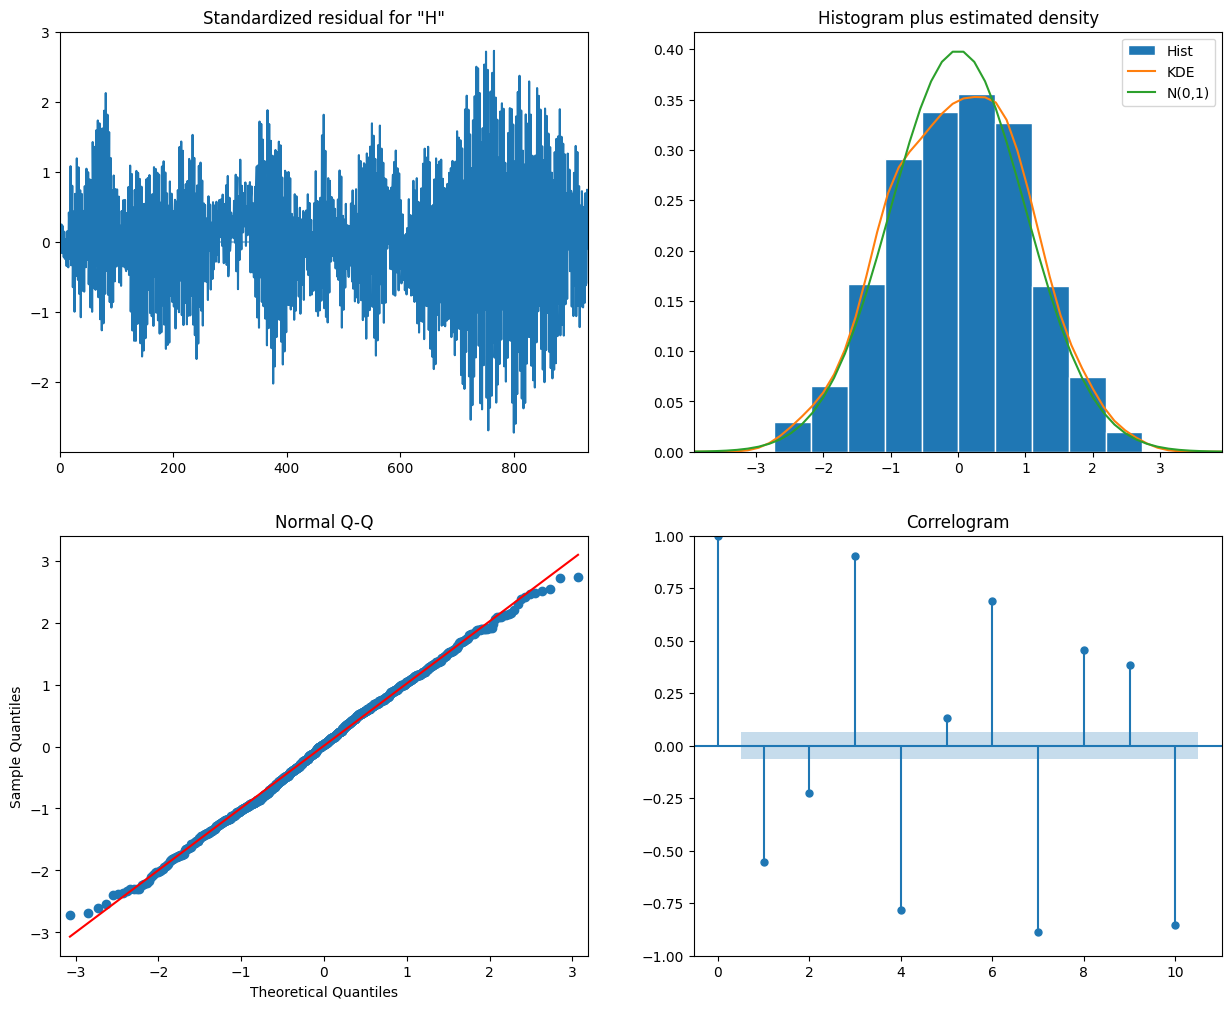

In [58]:
kur_arima_model = auto_arima(train_kur['HCHO_Reading'], seasonal=False, trace=True)
p,d,q = kur_arima_model.order
print(p,d,q)
arima_kur = ARIMA(train_kur['HCHO_Reading'], order=(p,d,q))
arima_fit_kur = arima_kur.fit()
print(arima_fit_kur.summary())
arima_fit_kur.plot_diagnostics(figsize=(15,12))

In [59]:
kur_test_preds_arima = arima_fit_kur.forecast(steps=len(test_kur))
rmse_kur_arima = root_mean_squared_error(test_kur['HCHO_Reading'], kur_test_preds_arima)
print(f'ARIMA RMSE for Kurunegala: {rmse_kur_arima}')
print(kur_test_preds_arima)

ARIMA RMSE for Kurunegala: 6.633206363599278e-05
932    -0.000051
933     0.000140
934     0.000158
935     0.000137
936     0.000137
          ...   
1161    0.000137
1162    0.000137
1163    0.000137
1164    0.000137
1165    0.000137
Name: predicted_mean, Length: 234, dtype: float64


SARIMA

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-15092.943, Time=5.43 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-15058.708, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-14780.425, Time=1.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-15109.098, Time=1.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-13654.443, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-15082.804, Time=0.37 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-14880.400, Time=1.70 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-15108.028, Time=2.80 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=-14770.445, Time=1.25 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=4.65 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-15087.221, Time=0.79 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-15154.753, Time=1.11 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-15140.776, Time=0.55 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-14827.441, Time=4.27 se

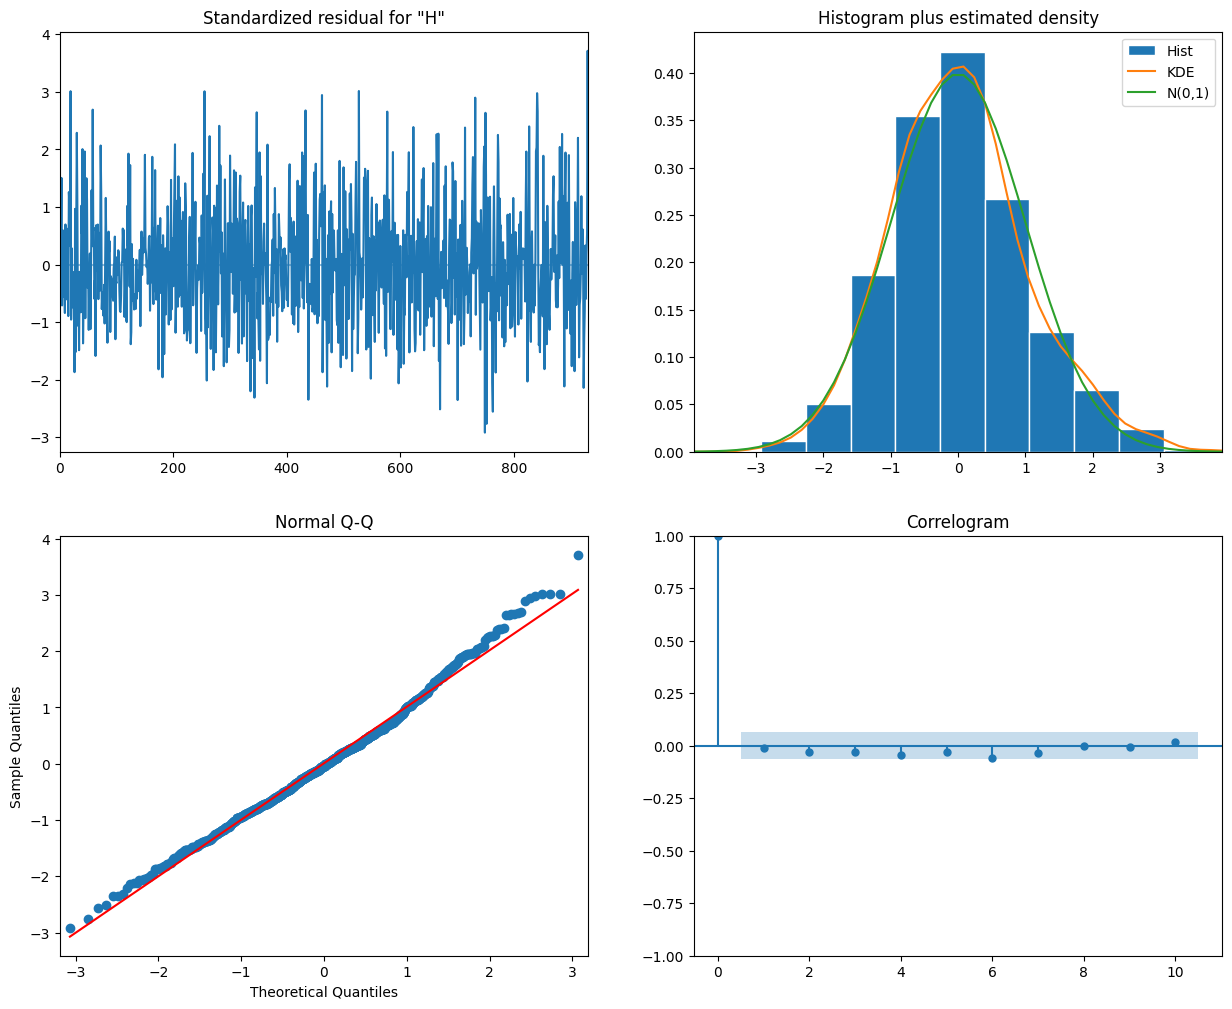

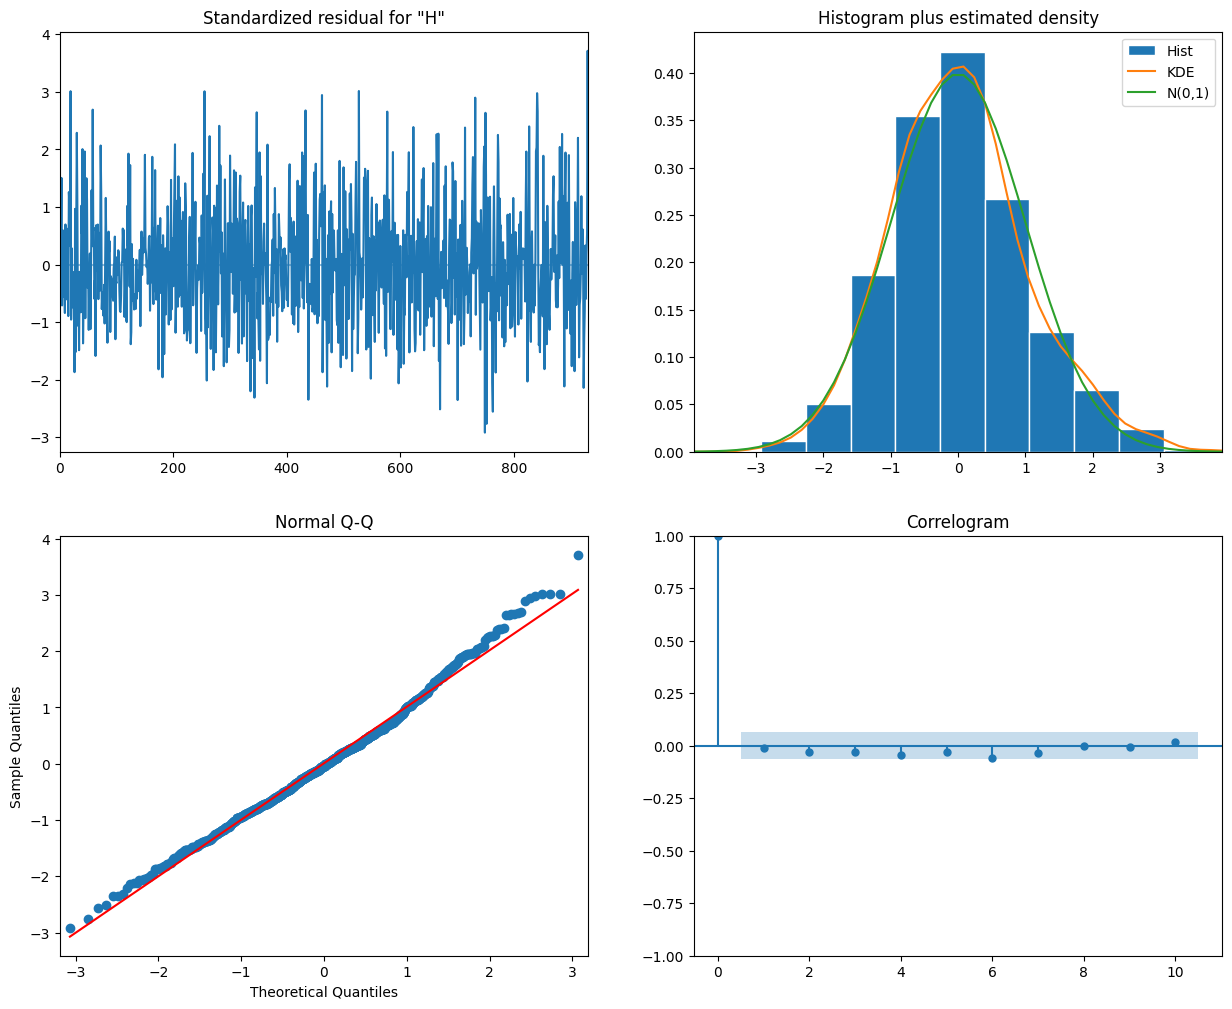

In [60]:
kur_sarima_model = auto_arima(train_kur['HCHO_Reading'], seasonal=True, trace=True, m=12)
p,d,q = kur_sarima_model.order
print(p,d,q)
sarima_kur = SARIMAX(train_kur['HCHO_Reading'], order=(p,d,q), seasonal_order=(p,d,q,12))
sarima_fit_kur = sarima_kur.fit()
print(sarima_fit_kur.summary())
sarima_fit_kur.plot_diagnostics(figsize=(15,12))

In [61]:
kur_test_preds_sarima = sarima_fit_kur.forecast(steps=len(test_kur))
rmse_kur_sarima = root_mean_squared_error(test_kur['HCHO_Reading'], kur_test_preds_sarima)
print(f'SARIMA RMSE for Kurunegala: {rmse_kur_sarima}')
print(kur_test_preds_sarima)

SARIMA RMSE for Kurunegala: 7.712883897375598e-05
932     0.000145
933     0.000218
934     0.000147
935     0.000132
936     0.000151
          ...   
1161    0.000201
1162    0.000143
1163    0.000145
1164    0.000158
1165    0.000159
Name: predicted_mean, Length: 234, dtype: float64


Gaussian Process

In [62]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp_kur = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

gp_kur.fit(train_kur.index.values.reshape(-1,1), train_kur['HCHO_Reading'])

kur_test_preds_gp = gp_kur.predict(test_kur.index.values.reshape(-1,1))
rmse_kur_gp = root_mean_squared_error(test_kur['HCHO_Reading'], kur_test_preds_gp)
print(f'Gaussian Process RMSE for Kurunegala: {rmse_kur_gp}')

Gaussian Process RMSE for Kurunegala: 0.00018168720041498865


## Jaffna

In [63]:
jaffna_df = pd.read_csv('jaffna_df.csv')
jaffna_df

HCHO_Reading Location Current_Date
0         0.000058   Jaffna   2019-01-01
1         0.000102   Jaffna   2019-01-02
2         0.000039   Jaffna   2019-01-03
3         0.000159   Jaffna   2019-01-05
4         0.000075   Jaffna   2019-01-06
...            ...      ...          ...
1376      0.000088   Jaffna   2023-12-24
1377      0.000051   Jaffna   2023-12-28
1378      0.000127   Jaffna   2023-12-29
1379      0.000117   Jaffna   2023-12-30
1380      0.000065   Jaffna   2023-12-31

[1381 rows x 3 columns]

In [64]:
drop_location(jaffna_df)
jaffna_df

HCHO_Reading Current_Date
0         0.000058   2019-01-01
1         0.000102   2019-01-02
2         0.000039   2019-01-03
3         0.000159   2019-01-05
4         0.000075   2019-01-06
...            ...          ...
1376      0.000088   2023-12-24
1377      0.000051   2023-12-28
1378      0.000127   2023-12-29
1379      0.000117   2023-12-30
1380      0.000065   2023-12-31

[1381 rows x 2 columns]

In [65]:
convert_to_datetime(jaffna_df)

HCHO_Reading Current_Date
0         0.000058   2019-01-01
1         0.000102   2019-01-02
2         0.000039   2019-01-03
3         0.000159   2019-01-05
4         0.000075   2019-01-06
...            ...          ...
1376      0.000088   2023-12-24
1377      0.000051   2023-12-28
1378      0.000127   2023-12-29
1379      0.000117   2023-12-30
1380      0.000065   2023-12-31

[1381 rows x 2 columns]

In [66]:
train_size_jaf = int(len(jaffna_df) * 0.8)
train_jaf, test_jaf = jaffna_df.iloc[:train_size_jaf], jaffna_df.iloc[train_size_jaf:]

ARIMA

Performing stepwise search to minimize aic


 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-18262.621, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-16710.317, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-17859.494, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-17164.568, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-18259.086, Time=0.37 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-18218.241, Time=0.11 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-18259.825, Time=0.40 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-16700.317, Time=0.54 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-18204.841, Time=0.29 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-12611.937, Time=0.36 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-18144.334, Time=0.21 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-18280.653, Time=0.37 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=-16696.318, Time=0.80 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=-16696.299, Time=0.82 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-18259

c:\Users\arkha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:           HCHO_Reading   No. Observations:                 1104
Model:                 ARIMA(3, 0, 3)   Log Likelihood                9159.625
Date:                Mon, 15 Apr 2024   AIC                         -18303.251
Time:                        20:09:09   BIC                         -18263.197
Sample:                             0   HQIC                        -18288.101
                               - 1104                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   1.96e-06     55.796      0.000       0.000       0.000
ar.L1              -0   2.97e-12         -0      1.000   -5.82e-12    5.82e-12
ar.L2              -0   4.28e-12         -0      1.0

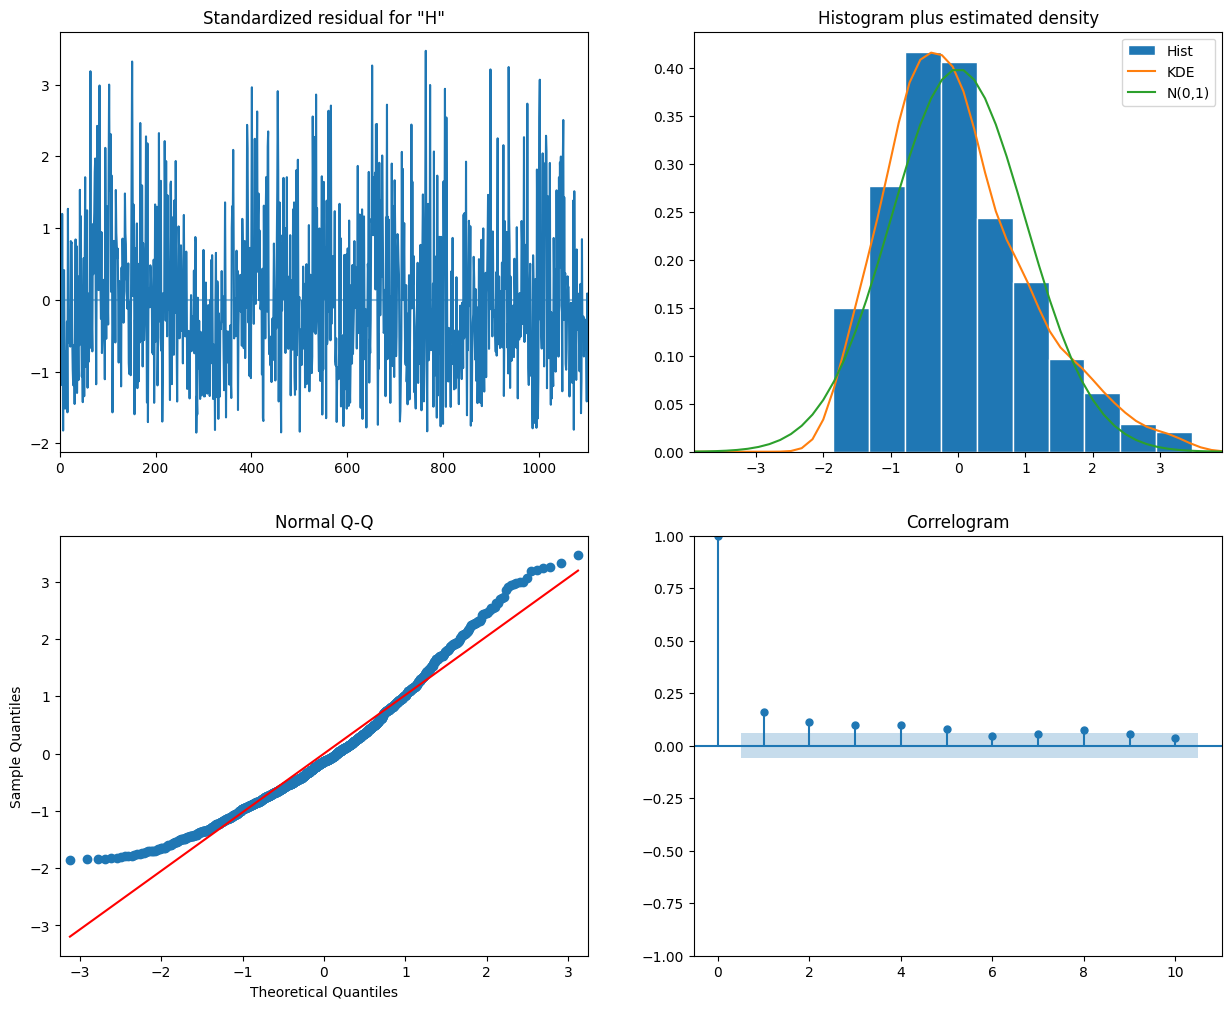

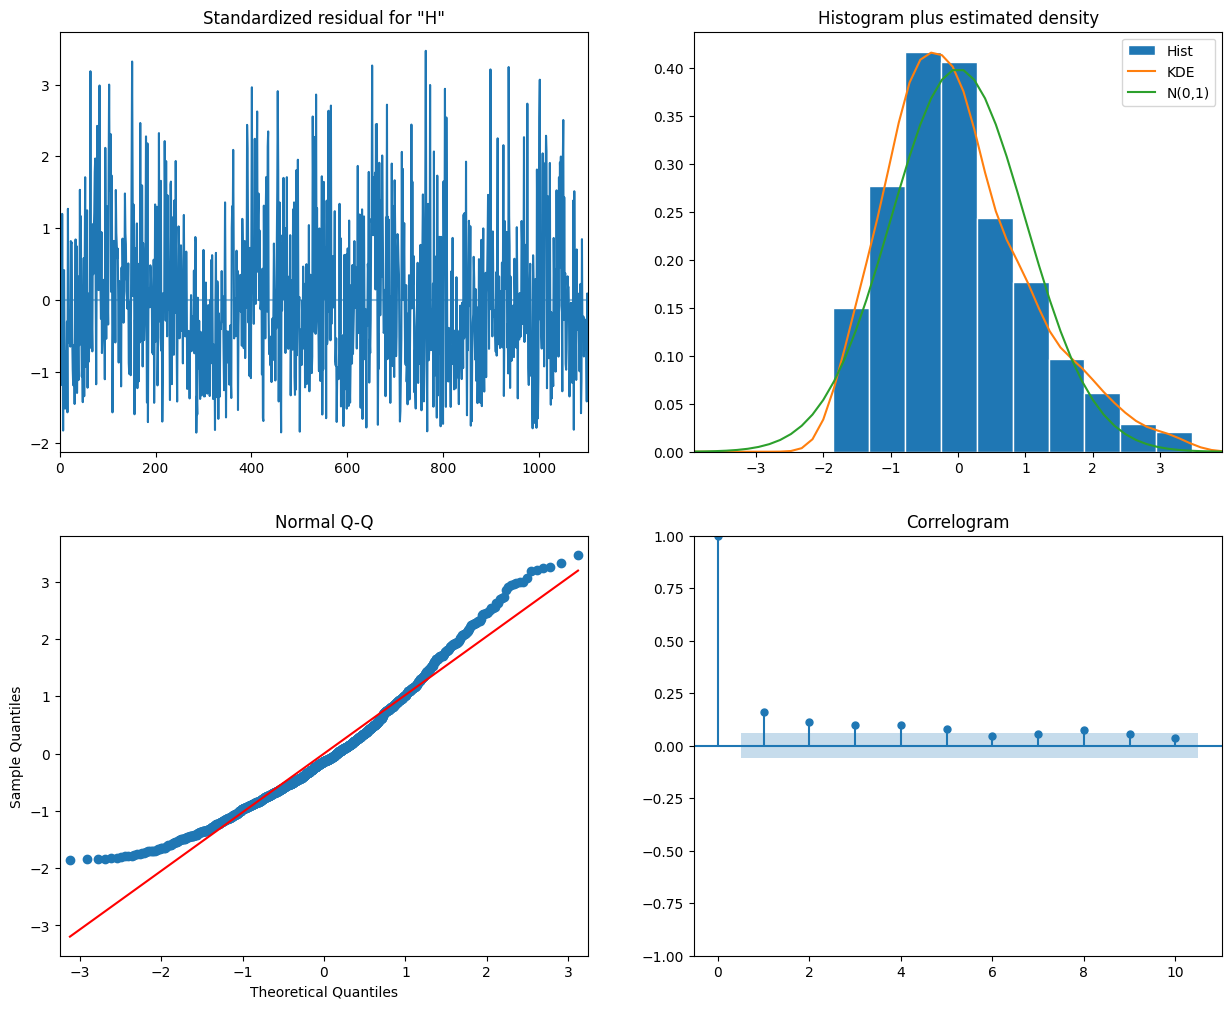

In [67]:
jaf_arima_model = auto_arima(train_jaf['HCHO_Reading'], seasonal=False, trace=True)
p,d,q = jaf_arima_model.order
print(p,d,q)
arima_jaf = ARIMA(train_jaf['HCHO_Reading'], order=(p,d,q))
arima_fit_jaf = arima_jaf.fit()
print(arima_fit_jaf.summary())
arima_fit_jaf.plot_diagnostics(figsize=(15,12))

In [68]:
jaf_test_preds_arima = arima_fit_jaf.forecast(steps=len(test_jaf))
rmse_jaf_arima = root_mean_squared_error(test_jaf['HCHO_Reading'], jaf_test_preds_arima)
print(f'ARIMA RMSE for Jaffna: {rmse_jaf_arima}')
print(jaf_test_preds_arima)

ARIMA RMSE for Jaffna: 6.231258720318001e-05
1104    0.000109
1105    0.000109
1106    0.000109
1107    0.000109
1108    0.000109
          ...   
1376    0.000109
1377    0.000109
1378    0.000109
1379    0.000109
1380    0.000109
Name: predicted_mean, Length: 277, dtype: float64


SARIMA

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=3.40 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-18316.561, Time=0.13 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-17849.725, Time=1.39 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-18330.941, Time=1.40 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-16710.317, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-18330.848, Time=0.43 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=2.28 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-18329.153, Time=3.73 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=-17846.319, Time=0.62 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=7.53 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-18317.090, Time=0.89 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-18344.158, Time=1.54 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-18344.995, Time=0.56 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-17847.786, Time=1.58 sec
 ARIMA(1,0,1

c:\Users\arkha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                       HCHO_Reading   No. Observations:                 1104
Model:             SARIMAX(5, 0, 0)x(5, 0, 0, 12)   Log Likelihood                9012.591
Date:                            Mon, 15 Apr 2024   AIC                         -18003.182
Time:                                    20:10:27   BIC                         -17948.108
Sample:                                         0   HQIC                        -17982.351
                                           - 1104                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2573   8.61e-20   2.99e+18      0.000       0.257       0.257
ar.L2          0.1816    1.5e-19   

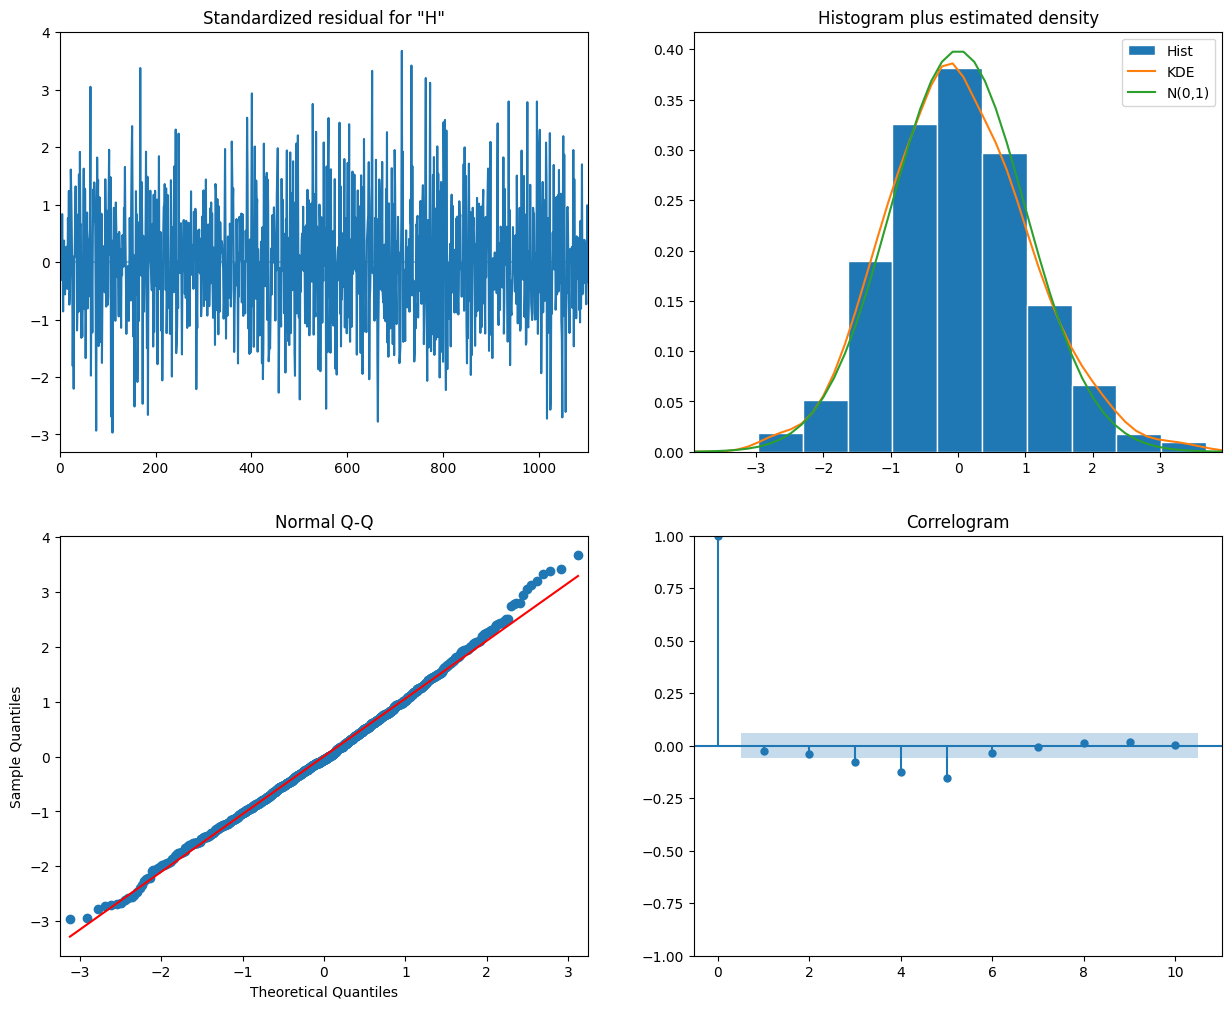

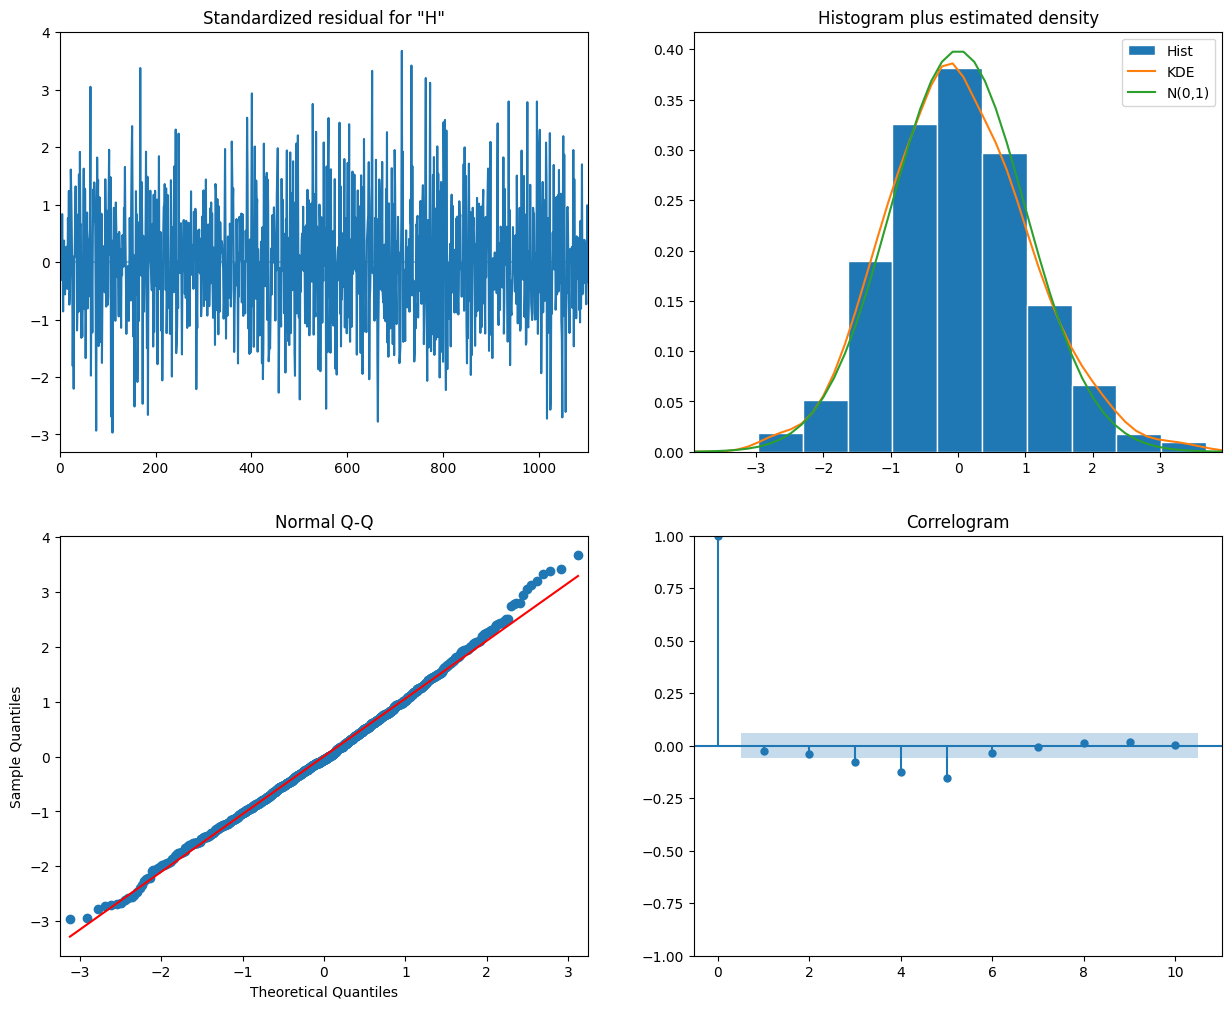

In [69]:
jaf_sarima_model = auto_arima(train_jaf['HCHO_Reading'], seasonal=True, trace=True, m=12)
p,d,q = jaf_sarima_model.order
print(p,d,q)
sarima_jaf = SARIMAX(train_jaf['HCHO_Reading'], order=(p,d,q), seasonal_order=(p,d,q,12))
sarima_fit_jaf = sarima_jaf.fit()
print(sarima_fit_jaf.summary())
sarima_fit_jaf.plot_diagnostics(figsize=(15,12))

In [70]:
jaf_test_preds_sarima = sarima_fit_jaf.forecast(steps=len(test_jaf))
rmse_jaf_sarima = root_mean_squared_error(test_jaf['HCHO_Reading'], jaf_test_preds_sarima)
print(f'SARIMA RMSE for Jaffna: {rmse_jaf_sarima}')
print(jaf_test_preds_sarima)

SARIMA RMSE for Jaffna: 9.289299213500388e-05
1104    0.000077
1105    0.000083
1106    0.000072
1107    0.000072
1108    0.000094
          ...   
1376    0.000012
1377    0.000038
1378    0.000040
1379    0.000049
1380    0.000035
Name: predicted_mean, Length: 277, dtype: float64


Gaussian Process

In [71]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp_jaf = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

gp_jaf.fit(train_jaf.index.values.reshape(-1,1), train_jaf['HCHO_Reading'])

jaf_test_preds_gp = gp_jaf.predict(test_jaf.index.values.reshape(-1,1))
rmse_jaf_gp = root_mean_squared_error(test_jaf['HCHO_Reading'], jaf_test_preds_gp)
print(f'Gaussian Process RMSE for Jaffna: {rmse_jaf_gp}')

Gaussian Process RMSE for Jaffna: 0.00013096628375176966


# Obtaining Predictions

In [31]:
import warnings
warnings.filterwarnings("ignore")

In [32]:
import pandas as pd
import os

In [33]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [34]:
# dropping the location column in the dataframes
def drop_location(dataframe):
    return dataframe.drop(columns=['Location'], inplace=True)

In [35]:
def convert_to_datetime(df):
    df['Current_Date'] = pd.to_datetime(df['Current_Date'])
    return df

## Colombo

In [48]:
colombo_df = pd.read_csv('colombo_df.csv')
colombo_df

HCHO_Reading Location Current_Date
0         0.000197  Colombo   2019-01-01
1         0.000263  Colombo   2019-01-02
2         0.000099  Colombo   2019-01-03
3         0.000210  Colombo   2019-01-04
4         0.000179  Colombo   2019-01-05
...            ...      ...          ...
1275      0.000182  Colombo   2023-12-24
1276      0.000343  Colombo   2023-12-25
1277      0.000118  Colombo   2023-12-27
1278      0.000140  Colombo   2023-12-30
1279      0.000080  Colombo   2023-12-31

[1280 rows x 3 columns]

In [49]:
drop_location(colombo_df)
colombo_df

HCHO_Reading Current_Date
0         0.000197   2019-01-01
1         0.000263   2019-01-02
2         0.000099   2019-01-03
3         0.000210   2019-01-04
4         0.000179   2019-01-05
...            ...          ...
1275      0.000182   2023-12-24
1276      0.000343   2023-12-25
1277      0.000118   2023-12-27
1278      0.000140   2023-12-30
1279      0.000080   2023-12-31

[1280 rows x 2 columns]

In [50]:
convert_to_datetime(colombo_df)
colombo_df.dtypes

HCHO_Reading           float64
Current_Date    datetime64[ns]
dtype: object

In [51]:
train_size_col = int(len(colombo_df) * 0.8)
train_col, test_col = colombo_df.iloc[:train_size_col], colombo_df.iloc[train_size_col:]
arima_colombo_final = ARIMA(train_col['HCHO_Reading'], order=(0,1,4))
arima_fit_colombo_final = arima_colombo_final.fit()
colombo_preds = arima_fit_colombo_final.forecast(steps=len(test_col))
print(colombo_preds)

1024    0.000137
1025    0.000142
1026    0.000142
1027    0.000140
1028    0.000140
          ...   
1275    0.000140
1276    0.000140
1277    0.000140
1278    0.000140
1279    0.000140
Name: predicted_mean, Length: 256, dtype: float64


In [52]:
# making future forecasts
forecast_horizon = 30

forecast_index = pd.date_range(start=colombo_df['Current_Date'].max(), periods=forecast_horizon + 1, freq='D')[1:]
forecast_index

# making the predictions
forecast_values= arima_fit_colombo_final.forecast(steps=forecast_horizon)

colombo_forecast_df = pd.DataFrame({'Date': forecast_index, 'HCHO_Reading': forecast_values})
colombo_forecast_df.set_index('Date', inplace=True)
colombo_forecast_df

HCHO_Reading
Date                    
2024-01-01      0.000137
2024-01-02      0.000142
2024-01-03      0.000142
2024-01-04      0.000140
2024-01-05      0.000140
2024-01-06      0.000140
2024-01-07      0.000140
2024-01-08      0.000140
2024-01-09      0.000140
2024-01-10      0.000140
2024-01-11      0.000140
2024-01-12      0.000140
2024-01-13      0.000140
2024-01-14      0.000140
2024-01-15      0.000140
2024-01-16      0.000140
2024-01-17      0.000140
2024-01-18      0.000140
2024-01-19      0.000140
2024-01-20      0.000140
2024-01-21      0.000140
2024-01-22      0.000140
2024-01-23      0.000140
2024-01-24      0.000140
2024-01-25      0.000140
2024-01-26      0.000140
2024-01-27      0.000140
2024-01-28      0.000140
2024-01-29      0.000140
2024-01-30      0.000140

In [53]:
directory = 'Final_Predictions'

if not os.path.exists(directory):
    os.makedirs(directory)

colombo_forecast_df.to_csv('Final_Predictions/colombo_forecast.csv')

## Matara

In [54]:
matara_df = pd.read_csv('matara_df.csv')
matara_df

HCHO_Reading Location Current_Date
0        0.000006   Matara   2019-01-02
1        0.000236   Matara   2019-01-03
2        0.000064   Matara   2019-01-04
3        0.000053   Matara   2019-01-05
4        0.000132   Matara   2019-01-06
..            ...      ...          ...
847      0.000063   Matara   2023-12-24
848      0.000072   Matara   2023-12-25
849      0.000059   Matara   2023-12-26
850      0.000228   Matara   2023-12-27
851      0.000116   Matara   2023-12-30

[852 rows x 3 columns]

In [55]:
drop_location(matara_df)
matara_df

HCHO_Reading Current_Date
0        0.000006   2019-01-02
1        0.000236   2019-01-03
2        0.000064   2019-01-04
3        0.000053   2019-01-05
4        0.000132   2019-01-06
..            ...          ...
847      0.000063   2023-12-24
848      0.000072   2023-12-25
849      0.000059   2023-12-26
850      0.000228   2023-12-27
851      0.000116   2023-12-30

[852 rows x 2 columns]

In [56]:
convert_to_datetime(matara_df)
matara_df.dtypes

HCHO_Reading           float64
Current_Date    datetime64[ns]
dtype: object

In [57]:
train_size_mat = int(len(matara_df) * 0.8)
train_mat, test_mat = matara_df.iloc[:train_size_mat], matara_df.iloc[train_size_mat:]
arima_matara_final = ARIMA(train_mat['HCHO_Reading'], order=(0,0,4))
arima_fit_matara_final = arima_matara_final.fit()
matara_preds = arima_fit_matara_final.forecast(steps=len(test_mat))
print(matara_preds)

681    0.000099
682    0.000101
683    0.000101
684    0.000105
685    0.000103
         ...   
847    0.000103
848    0.000103
849    0.000103
850    0.000103
851    0.000103
Name: predicted_mean, Length: 171, dtype: float64


In [58]:
forecast_horizon = 30

forecast_index = pd.date_range(start=matara_df['Current_Date'].max(), periods=forecast_horizon + 1, freq='D')[1:]

# Making the predictions
forecast_values = arima_fit_matara_final.forecast(steps=forecast_horizon)

# Create a dataframe for the forecast period
matara_forecast_df = pd.DataFrame({'Date': forecast_index, 'HCHO_Reading': forecast_values})
matara_forecast_df.set_index('Date', inplace=True)
matara_forecast_df

HCHO_Reading
Date                    
2023-12-31      0.000099
2024-01-01      0.000101
2024-01-02      0.000101
2024-01-03      0.000105
2024-01-04      0.000103
2024-01-05      0.000103
2024-01-06      0.000103
2024-01-07      0.000103
2024-01-08      0.000103
2024-01-09      0.000103
2024-01-10      0.000103
2024-01-11      0.000103
2024-01-12      0.000103
2024-01-13      0.000103
2024-01-14      0.000103
2024-01-15      0.000103
2024-01-16      0.000103
2024-01-17      0.000103
2024-01-18      0.000103
2024-01-19      0.000103
2024-01-20      0.000103
2024-01-21      0.000103
2024-01-22      0.000103
2024-01-23      0.000103
2024-01-24      0.000103
2024-01-25      0.000103
2024-01-26      0.000103
2024-01-27      0.000103
2024-01-28      0.000103
2024-01-29      0.000103

In [59]:
directory = 'Final_Predictions'

if not os.path.exists(directory):
    os.makedirs(directory)

matara_forecast_df.to_csv('Final_Predictions/matara_forecast.csv')

## Nuwara Eliya

In [60]:
nuwara_eliya_df = pd.read_csv('nuwara_eliya_df.csv')
nuwara_eliya_df

HCHO_Reading      Location Current_Date
0        0.000191  Nuwara Eliya   2019-01-03
1        0.000051  Nuwara Eliya   2019-01-04
2        0.000065  Nuwara Eliya   2019-01-05
3        0.000090  Nuwara Eliya   2019-01-06
4        0.000041  Nuwara Eliya   2019-01-07
..            ...           ...          ...
632      0.000041  Nuwara Eliya   2023-11-11
633      0.000036  Nuwara Eliya   2023-11-23
634      0.000108  Nuwara Eliya   2023-12-13
635      0.000006  Nuwara Eliya   2023-12-17
636      0.000237  Nuwara Eliya   2023-12-23

[637 rows x 3 columns]

In [61]:
drop_location(nuwara_eliya_df)
nuwara_eliya_df

HCHO_Reading Current_Date
0        0.000191   2019-01-03
1        0.000051   2019-01-04
2        0.000065   2019-01-05
3        0.000090   2019-01-06
4        0.000041   2019-01-07
..            ...          ...
632      0.000041   2023-11-11
633      0.000036   2023-11-23
634      0.000108   2023-12-13
635      0.000006   2023-12-17
636      0.000237   2023-12-23

[637 rows x 2 columns]

In [62]:
convert_to_datetime(nuwara_eliya_df)
nuwara_eliya_df.dtypes

HCHO_Reading           float64
Current_Date    datetime64[ns]
dtype: object

In [63]:
train_size_nuw = int(len(nuwara_eliya_df) * 0.8)
train_nuw, test_nuw = nuwara_eliya_df.iloc[:train_size_nuw], nuwara_eliya_df.iloc[train_size_nuw:]
arima_nuw_final = ARIMA(train_nuw['HCHO_Reading'], order=(5,0,0))
arima_fit_nuw_final = arima_nuw_final.fit()
nuwara_eliya_preds = arima_fit_nuw_final.forecast(steps=len(test_nuw))
print(nuwara_eliya_preds)

509    0.000106
510    0.000103
511    0.000104
512    0.000106
513    0.000111
         ...   
632    0.000105
633    0.000105
634    0.000105
635    0.000105
636    0.000105
Name: predicted_mean, Length: 128, dtype: float64


In [64]:
forecast_horizon = 30

forecast_index = pd.date_range(start=nuwara_eliya_df['Current_Date'].max(), periods=forecast_horizon + 1, freq='D')[1:]

# Making the predictions
forecast_values = arima_fit_nuw_final.forecast(steps=forecast_horizon)

# Create a dataframe for the forecast period
nuwara_eliya_forecast_df = pd.DataFrame({'Date': forecast_index, 'HCHO_Reading': forecast_values})
nuwara_eliya_forecast_df.set_index('Date', inplace=True)
nuwara_eliya_forecast_df

HCHO_Reading
Date                    
2023-12-24      0.000106
2023-12-25      0.000103
2023-12-26      0.000104
2023-12-27      0.000106
2023-12-28      0.000111
2023-12-29      0.000106
2023-12-30      0.000105
2023-12-31      0.000105
2024-01-01      0.000105
2024-01-02      0.000106
2024-01-03      0.000105
2024-01-04      0.000105
2024-01-05      0.000105
2024-01-06      0.000105
2024-01-07      0.000105
2024-01-08      0.000105
2024-01-09      0.000105
2024-01-10      0.000105
2024-01-11      0.000105
2024-01-12      0.000105
2024-01-13      0.000105
2024-01-14      0.000105
2024-01-15      0.000105
2024-01-16      0.000105
2024-01-17      0.000105
2024-01-18      0.000105
2024-01-19      0.000105
2024-01-20      0.000105
2024-01-21      0.000105
2024-01-22      0.000105

In [65]:
directory = 'Final_Predictions'

if not os.path.exists(directory):
    os.makedirs(directory)

nuwara_eliya_forecast_df.to_csv('Final_Predictions/nuwara_eliya_forecast.csv')

## Monaragala

In [66]:
monaragala_df = pd.read_csv('monaragala_df.csv')
monaragala_df

HCHO_Reading    Location Current_Date
0         0.000019  Monaragala   2019-01-02
1         0.000028  Monaragala   2019-01-03
2         0.000037  Monaragala   2019-01-04
3         0.000146  Monaragala   2019-01-06
4         0.000028  Monaragala   2019-01-07
...            ...         ...          ...
1034      0.000140  Monaragala   2023-12-11
1035      0.000188  Monaragala   2023-12-14
1036      0.000052  Monaragala   2023-12-18
1037      0.000149  Monaragala   2023-12-23
1038      0.000031  Monaragala   2023-12-25

[1039 rows x 3 columns]

In [67]:
drop_location(monaragala_df)
monaragala_df

HCHO_Reading Current_Date
0         0.000019   2019-01-02
1         0.000028   2019-01-03
2         0.000037   2019-01-04
3         0.000146   2019-01-06
4         0.000028   2019-01-07
...            ...          ...
1034      0.000140   2023-12-11
1035      0.000188   2023-12-14
1036      0.000052   2023-12-18
1037      0.000149   2023-12-23
1038      0.000031   2023-12-25

[1039 rows x 2 columns]

In [68]:
convert_to_datetime(monaragala_df)
monaragala_df.dtypes

HCHO_Reading           float64
Current_Date    datetime64[ns]
dtype: object

In [69]:
train_size_mon = int(len(monaragala_df) * 0.8)
train_mon, test_mon = monaragala_df.iloc[:train_size_mon], monaragala_df.iloc[train_size_mon:]
arima_mon_final = ARIMA(train_mon['HCHO_Reading'], order=(3,0,3))
arima_fit_mon_final = arima_mon_final.fit()
monaragala_preds = arima_fit_mon_final.forecast(steps=len(test_mon))
print(monaragala_preds)

831     0.000089
832     0.000157
833     0.000234
834     0.000091
835     0.000140
          ...   
1034    0.000079
1035    0.000168
1036    0.000160
1037    0.000079
1038    0.000161
Name: predicted_mean, Length: 208, dtype: float64


In [70]:
forecast_horizon = 30

forecast_index = pd.date_range(start=monaragala_df['Current_Date'].max(), periods=forecast_horizon + 1, freq='D')[1:]

# Making the predictions
forecast_values = arima_fit_mon_final.forecast(steps=forecast_horizon)

# Create a dataframe for the forecast period
monaragala_forecast_df = pd.DataFrame({'Date': forecast_index, 'HCHO_Reading': forecast_values})
monaragala_forecast_df.set_index('Date', inplace=True)
monaragala_forecast_df

HCHO_Reading
Date                    
2023-12-26      0.000089
2023-12-27      0.000157
2023-12-28      0.000234
2023-12-29      0.000091
2023-12-30      0.000140
2023-12-31      0.000233
2024-01-01      0.000095
2024-01-02      0.000125
2024-01-03      0.000232
2024-01-04      0.000102
2024-01-05      0.000112
2024-01-06      0.000230
2024-01-07      0.000109
2024-01-08      0.000099
2024-01-09      0.000226
2024-01-10      0.000118
2024-01-11      0.000088
2024-01-12      0.000221
2024-01-13      0.000128
2024-01-14      0.000079
2024-01-15      0.000215
2024-01-16      0.000138
2024-01-17      0.000072
2024-01-18      0.000208
2024-01-19      0.000148
2024-01-20      0.000066
2024-01-21      0.000200
2024-01-22      0.000159
2024-01-23      0.000062
2024-01-24      0.000190

In [71]:
directory = 'Final_Predictions'

if not os.path.exists(directory):
    os.makedirs(directory)

monaragala_forecast_df.to_csv('Final_Predictions/monaragala_forecast.csv')

## Kurunegala

In [72]:
kurunegala_df = pd.read_csv('kurunegala_df.csv')
kurunegala_df

HCHO_Reading    Location Current_Date
0         0.000088  Kurunegala   2019-01-01
1         0.000137  Kurunegala   2019-01-02
2         0.000148  Kurunegala   2019-01-03
3         0.000249  Kurunegala   2019-01-05
4         0.000102  Kurunegala   2019-01-06
...            ...         ...          ...
1161      0.000063  Kurunegala   2023-12-23
1162      0.000094  Kurunegala   2023-12-25
1163      0.000152  Kurunegala   2023-12-26
1164      0.000075  Kurunegala   2023-12-27
1165      0.000158  Kurunegala   2023-12-30

[1166 rows x 3 columns]

In [73]:
drop_location(kurunegala_df)
kurunegala_df

HCHO_Reading Current_Date
0         0.000088   2019-01-01
1         0.000137   2019-01-02
2         0.000148   2019-01-03
3         0.000249   2019-01-05
4         0.000102   2019-01-06
...            ...          ...
1161      0.000063   2023-12-23
1162      0.000094   2023-12-25
1163      0.000152   2023-12-26
1164      0.000075   2023-12-27
1165      0.000158   2023-12-30

[1166 rows x 2 columns]

In [74]:
convert_to_datetime(kurunegala_df)
kurunegala_df.dtypes

HCHO_Reading           float64
Current_Date    datetime64[ns]
dtype: object

In [75]:
train_size_kur = int(len(kurunegala_df) * 0.8)
train_kur, test_kur = kurunegala_df.iloc[:train_size_kur], kurunegala_df.iloc[train_size_kur:]
arima_kur_final = ARIMA(train_kur['HCHO_Reading'], order=(3,0,3))
arima_fit_kur_final = arima_kur_final.fit()
kurunegala_preds = arima_fit_kur_final.forecast(steps=len(test_kur))
print(kurunegala_preds)

932    -0.000051
933     0.000140
934     0.000158
935     0.000137
936     0.000137
          ...   
1161    0.000137
1162    0.000137
1163    0.000137
1164    0.000137
1165    0.000137
Name: predicted_mean, Length: 234, dtype: float64


In [76]:
forecast_horizon = 30

forecast_index = pd.date_range(start=kurunegala_df['Current_Date'].max(), periods=forecast_horizon + 1, freq='D')[1:]

# Making the predictions
forecast_values = arima_fit_kur_final.forecast(steps=forecast_horizon)

# Create a dataframe for the forecast period
kurunegala_forecast_df = pd.DataFrame({'Date': forecast_index, 'HCHO_Reading': forecast_values})
kurunegala_forecast_df.set_index('Date', inplace=True)
kurunegala_forecast_df

HCHO_Reading
Date                    
2023-12-31     -0.000051
2024-01-01      0.000140
2024-01-02      0.000158
2024-01-03      0.000137
2024-01-04      0.000137
2024-01-05      0.000137
2024-01-06      0.000137
2024-01-07      0.000137
2024-01-08      0.000137
2024-01-09      0.000137
2024-01-10      0.000137
2024-01-11      0.000137
2024-01-12      0.000137
2024-01-13      0.000137
2024-01-14      0.000137
2024-01-15      0.000137
2024-01-16      0.000137
2024-01-17      0.000137
2024-01-18      0.000137
2024-01-19      0.000137
2024-01-20      0.000137
2024-01-21      0.000137
2024-01-22      0.000137
2024-01-23      0.000137
2024-01-24      0.000137
2024-01-25      0.000137
2024-01-26      0.000137
2024-01-27      0.000137
2024-01-28      0.000137
2024-01-29      0.000137

In [77]:
directory = 'Final_Predictions'

if not os.path.exists(directory):
    os.makedirs(directory)

kurunegala_forecast_df.to_csv('Final_Predictions/kurunegala_forecast.csv')

## Jaffna

In [78]:
jaffna_df = pd.read_csv('jaffna_df.csv')
jaffna_df

HCHO_Reading Location Current_Date
0         0.000058   Jaffna   2019-01-01
1         0.000102   Jaffna   2019-01-02
2         0.000039   Jaffna   2019-01-03
3         0.000159   Jaffna   2019-01-05
4         0.000075   Jaffna   2019-01-06
...            ...      ...          ...
1376      0.000088   Jaffna   2023-12-24
1377      0.000051   Jaffna   2023-12-28
1378      0.000127   Jaffna   2023-12-29
1379      0.000117   Jaffna   2023-12-30
1380      0.000065   Jaffna   2023-12-31

[1381 rows x 3 columns]

In [79]:
drop_location(jaffna_df)
jaffna_df

HCHO_Reading Current_Date
0         0.000058   2019-01-01
1         0.000102   2019-01-02
2         0.000039   2019-01-03
3         0.000159   2019-01-05
4         0.000075   2019-01-06
...            ...          ...
1376      0.000088   2023-12-24
1377      0.000051   2023-12-28
1378      0.000127   2023-12-29
1379      0.000117   2023-12-30
1380      0.000065   2023-12-31

[1381 rows x 2 columns]

In [80]:
convert_to_datetime(jaffna_df)
jaffna_df.dtypes

HCHO_Reading           float64
Current_Date    datetime64[ns]
dtype: object

In [81]:
train_size_jaf = int(len(jaffna_df) * 0.8)
train_jaf, test_jaf = jaffna_df.iloc[:train_size_jaf], jaffna_df.iloc[train_size_jaf:]
arima_jaf_final = ARIMA(train_jaf['HCHO_Reading'], order=(3,0,3))
arima_fit_jaf_final = arima_jaf_final.fit()
jaffna_preds = arima_fit_jaf_final.forecast(steps=len(test_jaf))
print(jaffna_preds)

1104    0.000109
1105    0.000109
1106    0.000109
1107    0.000109
1108    0.000109
          ...   
1376    0.000109
1377    0.000109
1378    0.000109
1379    0.000109
1380    0.000109
Name: predicted_mean, Length: 277, dtype: float64


In [82]:
forecast_horizon = 30

forecast_index = pd.date_range(start=jaffna_df['Current_Date'].max(), periods=forecast_horizon + 1, freq='D')[1:]

# Making the predictions
forecast_values = arima_fit_jaf_final.forecast(steps=forecast_horizon)

# Create a dataframe for the forecast period
jaffna_forecast_df = pd.DataFrame({'Date': forecast_index, 'HCHO_Reading': forecast_values})
jaffna_forecast_df.set_index('Date', inplace=True)
jaffna_forecast_df

HCHO_Reading
Date                    
2024-01-01      0.000109
2024-01-02      0.000109
2024-01-03      0.000109
2024-01-04      0.000109
2024-01-05      0.000109
2024-01-06      0.000109
2024-01-07      0.000109
2024-01-08      0.000109
2024-01-09      0.000109
2024-01-10      0.000109
2024-01-11      0.000109
2024-01-12      0.000109
2024-01-13      0.000109
2024-01-14      0.000109
2024-01-15      0.000109
2024-01-16      0.000109
2024-01-17      0.000109
2024-01-18      0.000109
2024-01-19      0.000109
2024-01-20      0.000109
2024-01-21      0.000109
2024-01-22      0.000109
2024-01-23      0.000109
2024-01-24      0.000109
2024-01-25      0.000109
2024-01-26      0.000109
2024-01-27      0.000109
2024-01-28      0.000109
2024-01-29      0.000109
2024-01-30      0.000109

In [83]:
directory = 'Final_Predictions'

if not os.path.exists(directory):
    os.makedir(directory)

jaffna_forecast_df.to_csv('Final_Predictions/jaffna_df.csv')